In [1]:
%pylab inline
from scipy.optimize import minimize
from scipy.integrate import simps
from scipy.special import spherical_jn
import os,sys
from scipy.interpolate import interp1d
sys.path.append('/home/ophilcox/EffectiveHalos/')
import EffectiveHalos as ph

Populating the interactive namespace from numpy and matplotlib


# Load quijote spectra (from Planck)

In [2]:
res = 512.
L_box = 1000.

z=0

In [3]:
all_Pk=[]
for sim in range(1000):
    infile='/projects/QUIJOTE/Pk/matter/Mnu_ppp/%d/Pk_m_z=%.0f.txt'%(sim,z)
    if not os.path.exists(infile):
        continue
    k,Pk = np.loadtxt(infile).T
    nbar = pow(res/L_box,3.)
    Pk-=1./nbar
    all_Pk.append(Pk)
all_Pk = np.asarray(all_Pk)
mean_Pk = all_Pk.mean(axis=0)
std_Pk = all_Pk.std(axis=0)
n_mocks = len(all_Pk)
k = np.asarray(k)
print('Using %d mocks'%n_mocks)

Using 500 mocks


### Load in Quijote model

In [4]:
class_params = {'h':0.6711,"T_cmb":2.7255,"Omega_b":0.049,"Omega_cdm":0.2589643720,"Omega_ncdm":"0.0031785425,0.0031785425,0.0031785425",
                "YHe":0.24,'N_ncdm':3,"n_s":0.9624,"z_pk":z,"N_ur":0.046,#0641,
                "output":"mPk,mTk",#,tCl,lCl",
               'P_k_max_h/Mpc':100,
               #"A_s":2.739100e-09,
                "T_ncdm":"0.7133,0.7133,0.7133",
               'sigma8':0.834
                #"tol_ncdm_synchronous":1e-10,
               #"transfer_neglect_delta_k_S_t0":100.,
               #"transfer_neglect_delta_k_S_t1":100.,
               #"transfer_neglect_delta_k_S_t2":100.,
               #"transfer_neglect_delta_k_S_e":100.,
               #"k_step_sub":0.015,
                #"k_step_super":0.0001,
                #"k_step_super_reduction":0.1,
                #"tol_ncdm_bg":1.e-10,
                #"k_scalar_min_eta0":0.002,
                #"k_scalar_max_eta0_over_l_max":3.,
                #"k_scalar_step_sub":0.015,
                #"k_scalar_step_super":0.0001, # was 0.0005
                #"k_scalar_step_transition":0.2, # was 0.2

}

In [5]:
kk = np.logspace(-4,1,1000)

In [6]:
cosm = ph.Cosmology(z,verb=True,npoints=1000,**class_params)
mf = ph.MassFunction(cosm,'Bhattacharya')
hp = ph.HaloPhysics(cosm,mf,npoints=300);

kh_min = 0.#np.pi*2./L_box

halop = ph.HaloModel(cosm,mf,hp,kk,kh_min)

Loading CLASS
Using a neutrino fraction of Omega_nu = 9.536e-03
Creating an interpolator for sigma(M) and its derivative.


In [10]:
cosm.cosmo.Omega_nu/cosm.cosmo.Omega_m()

0.030033472488241696

In [11]:
# Schmidt correction term

mi = halop.mass_integrals

dn_dm = mi._compute_mass_function()
b_m = mi._compute_linear_bias()
m_u_m = mi._compute_fourier_profile()
m_u_m_0 = hp.halo_profile(mi.m_h_grid,-1,True)

n_m_u2 = dn_dm*m_u_m**2
R_L = np.power(3.*mi.m_h_grid/(4.*np.pi*cosm.rhoM),1./3.)
    
nmu2_sq = n_m_u2[:,:,np.newaxis]*n_m_u2[:,np.newaxis,:]
R_L_sum = ((R_L.reshape(-1,1)+R_L.reshape(1,-1)))[np.newaxis,:,:]
Theta = (1. + (kk[:,np.newaxis,np.newaxis]*R_L_sum)**4.)**(-1.)

one_halo_lim = simps(dn_dm*m_u_m_0**2.,mi.logM_h_grid)

I_20_corr = simps(simps(nmu2_sq*Theta,mi.logM_h_grid,axis=1),mi.logM_h_grid,axis=1)/one_halo_lim

### Define models

In [12]:
f_nu = cosm.cosmo.Omega_nu/cosm.cosmo.Omega_m()

In [14]:
vector_cb = np.vectorize(lambda k: cosm.cosmo.pk_cb_lin(k*cosm.h,z)*cosm.h**3.)
vector_m = np.vectorize(lambda k: cosm.cosmo.pk_lin(k*cosm.h,z)*cosm.h**3.)

In [15]:
def pk_m_lin(pars):
    # Just linear matter field
    return vector_m(kk)
def pk_shm(pars):
    # Standard HM for cb and linear for neutrinos
    return halop.halo_model(pars[0],pars[1],'Linear',0,0,0,1) - I_20_corr*(1.-f_nu)**2.
def pk_ehm(pars):
    # Effective HM for cb and linear for neutrinos
    return halop.halo_model(pars[0],pars[1],'EFT') - I_20_corr*(1.-f_nu)**2.
def pk_ehm_no_low_k(pars):
    # Effective HM for cb and linear for neutrinos without Schmidt correction
    return halop.halo_model(pars[0],pars[1],'EFT')

In [16]:
model = {r'$P_\mathrm{L}(k)$':pk_m_lin,'SHM':pk_shm,'EHM':pk_ehm,
         'EHM without low-k':pk_ehm_no_low_k}
names = model.keys()

cols = ['red','blue','green','purple','orange','cyan','green']
k_fit = 0.8
n_fit = np.where(k<k_fit)[0][-1]

print('Fitting up to %.2f'%k[n_fit])

nbody_mean = all_Pk.mean(axis=0)
nbody_std = all_Pk.std(axis=0)/np.sqrt(len(all_Pk))

# Define covariance parameters
dk = np.mean(np.diff(k))
survey_vol = L_box**3.
N_modes = k**2.*dk*survey_vol/(2.*np.pi**2.)

Fitting up to 0.79


#### Define spectra binning

In [17]:
import Pk_library as PKL

In [18]:
def bin_spectra(kk,model,k_max_bin=0.1):
    bk,bpk,_=PKL.expected_Pk(kk.astype('float32'),model.astype('float32'),L_box,48)
    bk = np.asarray(bk)
    bpk = np.asarray(bpk)
    assert max(bk)>1.5*k_max_bin
    pk_out = interp1d(kk,model.copy())(k)
    pk_out[k<=k_max_bin] = bpk[bk<=k_max_bin]
    return pk_out

In [19]:
# define bins (k-dk/2,k+dk/2)
k_lo = (k-dk/2).reshape(-1,1)
ff = np.arange(0,1,0.01).reshape(1,-1)
k_grid = k_lo+ff*dk

def fit_model(model):
    def chi2(par):
        pred = bin_spectra(kk,model(par))[:n_fit]
        cov_Pk_diag = pred**2.*2./N_modes[:n_fit]
        prec_diag = 1./cov_Pk_diag
        prec = np.diag(prec_diag)
        diff = pred - nbody_mean[:n_fit]
        chi2val = np.matmul(diff.T,np.matmul(prec,diff))
        return chi2val
    x = minimize(chi2,[1.,1.])
    return x.x

fit_pars = []
for n,name in enumerate(names):
    print(name)
    fit_par = fit_model(model[name])
    fit_pars.append(fit_par)

EHM without low-k
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.01
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0

Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.

In [20]:
dd=np.load('neutrino_pk_fits_naive_v2.npz')

('Model: "EHM without low-k", parameters: ', array([ 7.97601790e+00, -2.97776956e-03]))
('Model: "EHM", parameters: ', array([7.97542904e+00, 1.40438261e-03]))
('Model: "SHM", parameters: ', array([1., 1.]))
('Model: "$P_\\mathrm{L}(k)$", parameters: ', array([1., 1.]))
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00
Time take = 0.00


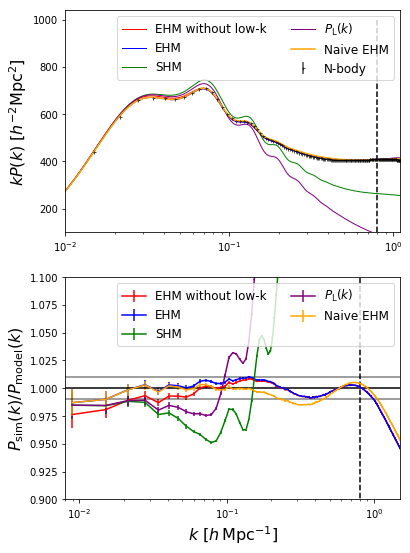

In [23]:
fig,ax = plt.subplots(2,1,figsize=(6,9))
ax[0].errorbar(k,k*nbody_mean,yerr=k*nbody_std,label='N-body',ls='',marker='+',ms=3,c='k',alpha=0.7)
for n,name in enumerate(names):
    fit_par = fit_pars[n]
    print('Model: "%s", parameters: '%name,fit_par)
    pred = model[name](fit_par)
    alp = 1.
    lw = 1
    ax[0].plot(kk,kk*pred,label=name,alpha=alp,c=cols[n],lw=lw)
#ax[0].plot(kk,kk*dd.f.pk_ehm_no_low_k,c='red',ls='--')
ax[0].plot(kk,kk*dd.f.pk_ehm,c='orange',ls='-',label=r'Naive EHM')
#ax[0].plot(kk,kk*dd.f.pk_shm,c='green',ls='--')
#ax[0].plot(kk,kk*dd.f.pk_m_lin,c='purple',ls='--')
ax[0].legend(fontsize=12,ncol=2)
ax[0].set_ylim([100.,1040])
ax[0].vlines(k_fit,0,1000,color='k',alpha=1.,linestyles='--')
ax[0].set_ylabel(r'$kP(k)$ [$h^{-2}\mathrm{Mpc}^{2}$]',fontsize=16)
#ax[0].set_xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=16)
ax[0].set_xlim([0.01,1.1]);
ax[0].set_xscale('log')

for n,name in enumerate(names):
    fit_par = fit_pars[n]
    pred = interp1d(kk,model[name](fit_par))(k)
    pred = bin_spectra(kk,model[name](fit_par))
    ax[1].errorbar(k,nbody_mean/pred,yerr=nbody_std/pred,label=name,alpha=alp,c=cols[n])
#mod = bin_spectra(kk,dd.f.pk_ehm_no_low_k)
#ax[1].errorbar(k,nbody_mean/mod,yerr=nbody_std/mod,c='red',ls=':',alpha=0.5,marker='')
mod = bin_spectra(kk,dd.f.pk_ehm)
ax[1].errorbar(k,nbody_mean/mod,yerr=nbody_std/mod,c='orange',ls='-',label=r'Naive EHM')#,alpha=0.5,marker='')
#mod = bin_spectra(kk,dd.f.pk_shm)
#ax[1].errorbar(k,nbody_mean/mod,yerr=nbody_std/mod,c='green',ls=':',alpha=0.5,marker='')
#mod = bin_spectra(kk,dd.f.pk_m_lin)
#ax[1].errorbar(k,nbody_mean/mod,yerr=nbody_std/mod,c='purple',ls=':',alpha=0.5,marker='')
ax[1].set_ylabel(r'$P_\mathrm{sim}(k)/P_\mathrm{model}(k)$',fontsize=16)
ax[1].set_xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=16)
ax[1].hlines(1.,0.001,10.,color='k',alpha=1)
ax[1].hlines([0.99,1.01],0.001,10.,color='k',alpha=0.5)
ax[1].vlines(k_fit,0,2,color='k',alpha=1.,linestyles='--')
ax[1].set_ylim([0.9,1.1])
ax[1].set_xscale('log')
ax[1].legend(fontsize=12,ncol=2,loc='upper right')
ax[1].set_xlim([0.008,1.5]);
plt.savefig('figs/neutrino_ehm.pdf',bbox_inches='tight')

(0, 1)

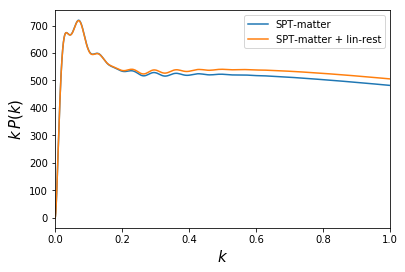

In [148]:
pk_cb_spt = halop.non_linear_power(0,0,'SPT',0,0,0)
plt.plot(kk,kk*dd.f.pk_m_spt,label='SPT-matter');
#plt.plot(kk,kk*pk_cb_spt,label='SPT-cb')
plt.plot(kk,kk*(pk_cb_spt*(1.-f_nu)**2.+(vector_m(kk)-(1.-f_nu)**2.*vector_cb(kk))),label='SPT-matter + lin-rest')
plt.legend();
plt.ylabel(r'$k\,P(k)$',fontsize=15);
plt.xlabel(r'$k$',fontsize=15);
plt.xlim([0,1])

(0, 1)

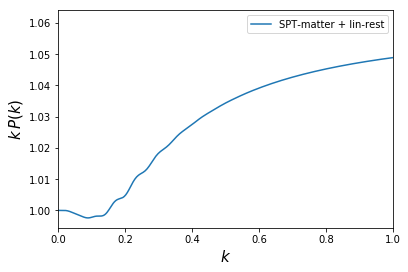

In [153]:
pk_cb_spt = halop.non_linear_power(0,0,'SPT',0,0,0)
#plt.plot(kk,kk*dd.f.pk_m_spt,label='SPT-matter');
#plt.plot(kk,kk*pk_cb_spt,label='SPT-cb')
plt.plot(kk,(pk_cb_spt*(1.-f_nu)**2.+(vector_m(kk)-(1.-f_nu)**2.*vector_cb(kk)))/dd.f.pk_m_spt,label='SPT-matter + lin-rest')
plt.legend();
plt.ylabel(r'$k\,P(k)$',fontsize=15);
plt.xlabel(r'$k$',fontsize=15);
plt.xlim([0,1])

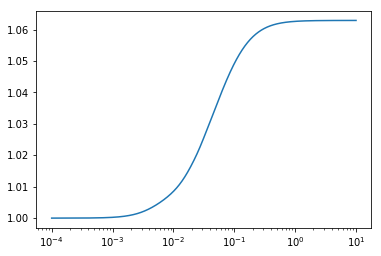

In [151]:
plt.semilogx(kk,vector_cb(kk)/vector_m(kk))

In [91]:
# np.savez('neutrino_pk_fits',kk=kk,k=k,pk_ehm=pk_ehm(fit_pars[0]),
#         pk_ehm_no_low_k=pk_ehm_no_low_k(fit_pars[1]),pk_shm=pk_shm(fit_pars[2]),pk_m_lin=pk_m_lin(fit_pars[3]))

# SCRATCH!

### First load in CLASS linear theory and check with input data

In [4]:
inp_k=np.loadtxt('/projects/QUIJOTE/Linear_Pk/Mnu_ppp/ICs/0.40eV_Pm_rescaled_z0.0000.txt')[:,0]
inp_m=np.loadtxt('/projects/QUIJOTE/Linear_Pk/Mnu_ppp/ICs/0.40eV_Pm_rescaled_z0.0000.txt')[:,1]
inp_cb=np.loadtxt('/projects/QUIJOTE/Linear_Pk/Mnu_ppp/ICs/0.40eV_Pcb_rescaled_z0.0000.txt')[:,1]
inp_cb_int = interp1d(inp_k,inp_cb)
inp_m_int = interp1d(inp_k,inp_m)

In [5]:
from classy import Class

In [6]:
class_params = {'h':0.6711,"T_cmb":2.7255,"Omega_b":0.049,"Omega_cdm":0.2589643720,"Omega_ncdm":"0.0031785425,0.0031785425,0.0031785425",
                "YHe":0.24,'N_ncdm':3,"n_s":0.9624,"z_pk":z,"N_ur":0.046,#0641,
                "output":"mPk,mTk",#,tCl,lCl",
               'P_k_max_h/Mpc':100,
               "A_s":2.739100e-09,"T_ncdm":"0.7133,0.7133,0.7133",
               #"tol_ncdm_synchronous":1e-10,
               #"transfer_neglect_delta_k_S_t0":100.,
               #"transfer_neglect_delta_k_S_t1":100.,
               #"transfer_neglect_delta_k_S_t2":100.,
               #"transfer_neglect_delta_k_S_e":100.,
               #"k_step_sub":0.015,
                #"k_step_super":0.0001,
                #"k_step_super_reduction":0.1,
                #"tol_ncdm_bg":1.e-10,
                #"k_scalar_min_eta0":0.002,
                #"k_scalar_max_eta0_over_l_max":3.,
                #"k_scalar_step_sub":0.015,
                #"k_scalar_step_super":0.0001, # was 0.0005
                #"k_scalar_step_transition":0.2, # was 0.2

}

In [7]:
cosmo = Class()
cosmo.set(class_params)
cosmo.compute()
h = cosmo.h()
vector_cb = np.vectorize(lambda k: cosmo.pk_cb_lin(k*h,z)*h**3.)
vector_m = np.vectorize(lambda k: cosmo.pk_lin(k*h,z)*h**3.)

kk = np.logspace(-4,1,1000)

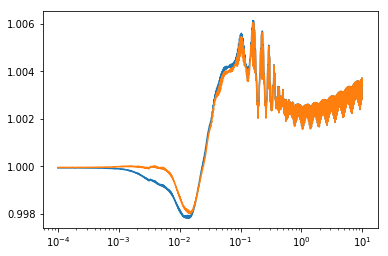

In [8]:
plt.semilogx(kk,inp_cb_int(kk)/vector_cb(kk))
plt.semilogx(kk,inp_m_int(kk)/vector_m(kk))

In [9]:
### Load binned linear power specta from files
binned_lin = np.loadtxt('/projects/QUIJOTE/Snapshots/Mnu_ppp/ICs/expected_Pk_z=0.txt')
bin_k, bin_pk = binned_lin[:,:2].T

In [10]:
import Pk_library as PKL

In [31]:
bk,bpk,bn = PKL.expected_Pk(kk.astype('float32'),vector_m(kk).astype('float32'),L_box,512)
bk = np.asarray(bk)
bpk = np.asarray(bpk)
bn = np.asarray(bn)

Time take = 2.73


#### Check halo model with linear theory from CAMB vs CLASS

In [40]:
kk = k
sys.path.append('/home/ophilcox/EffectiveHalos/')
import EffectiveHalos as ph
reload(ph);

cosm = ph.Cosmology(z,npoints=1000,**class_params)
mf = ph.MassFunction(cosm,'Bhattacharya')
hp = ph.HaloPhysics(cosm,mf,npoints=300);

kh_min = 0.#np.pi*2./L_box
halop = ph.HaloModel(cosm,mf,hp,kk,kh_min)

In [41]:
f_nu = cosm.cosmo.Omega_nu/cosm.cosmo.Omega_m()

Define Schmidt16 correction term

In [42]:
mi = halop.mass_integrals

dn_dm = mi._compute_mass_function()
b_m = mi._compute_linear_bias()
m_u_m = mi._compute_fourier_profile()
m_u_m_0 = hp.halo_profile(mi.m_h_grid,-1,True)

n_m_u2 = dn_dm*m_u_m**2
R_L = np.power(3.*mi.m_h_grid/(4.*np.pi*cosm.rhoM),1./3.)
    
nmu2_sq = n_m_u2[:,:,np.newaxis]*n_m_u2[:,np.newaxis,:]
R_L_sum = ((R_L.reshape(-1,1)+R_L.reshape(1,-1)))[np.newaxis,:,:]
Theta = (1. + (kk[:,np.newaxis,np.newaxis]*R_L_sum)**4.)**(-1.)

one_halo_lim = simps(dn_dm*m_u_m_0**2.,mi.logM_h_grid)

I_20_corr = simps(simps(nmu2_sq*Theta,mi.logM_h_grid,axis=1),mi.logM_h_grid,axis=1)/one_halo_lim

In [43]:
_=halop.halo_model(1,1)

In [44]:
def shm_camb(pars):
    return bin_pk
#    return vector_m(kk)
    #return (1.-f_nu)**2.*(inp_cb_int(kk)*halop.I_11**2.+halop.I_20-I_20_corr)+inp_m_int(kk)-inp_cb_int(kk)*(1.-f_nu)**2.
def shm_class(pars):
    return (1.-f_nu)**2.*(vector_cb(kk)*halop.I_11**2.+halop.I_20-I_20_corr)+vector_m(kk)-vector_cb(kk)*(1.-f_nu)**2.

In [45]:
nbody_mean = np.mean(all_Pk,axis=0)
nbody_std = np.std(all_Pk,axis=0)/np.sqrt(len(all_Pk))

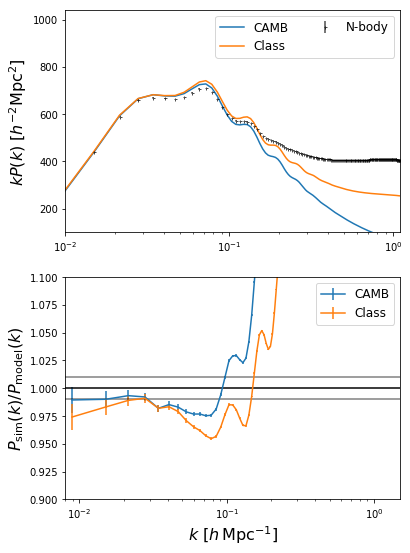

In [46]:
fig,ax = plt.subplots(2,1,figsize=(6,9))
ax[0].errorbar(k,k*nbody_mean,yerr=k*nbody_std,label='N-body',ls='',marker='+',ms=3,c='k',alpha=0.7)
pred = interp1d(kk,shm_camb([]))(k) 
ax[0].plot(k,k*pred,label='CAMB')
pred = interp1d(kk,shm_class([]))(k) 
ax[0].plot(k,k*pred,label='Class')
ax[0].legend(fontsize=12,ncol=2)
ax[0].set_ylim([100.,1040])
#ax[0].vlines(k_fit,0,1000,color='k',alpha=1.,linestyles='--')
ax[0].set_ylabel(r'$kP(k)$ [$h^{-2}\mathrm{Mpc}^{2}$]',fontsize=16)
#ax[0].set_xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=16)
ax[0].set_xlim([0.01,1.1]);
ax[0].set_xscale('log')

pred = interp1d(kk,shm_camb([]))(k) 
ax[1].errorbar(k,nbody_mean/pred,yerr=nbody_std/pred,label='CAMB')
pred = interp1d(kk,shm_class([]))(k) 
ax[1].errorbar(k,nbody_mean/pred,yerr=nbody_std/pred,label='Class')
ax[1].set_ylabel(r'$P_\mathrm{sim}(k)/P_\mathrm{model}(k)$',fontsize=16)
ax[1].set_xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=16)
ax[1].hlines(1.,0.001,10.,color='k',alpha=1)
ax[1].hlines([0.99,1.01],0.001,10.,color='k',alpha=0.5)
#ax[1].vlines(k_fit,0,2,color='k',alpha=1.,linestyles='--')
ax[1].set_ylim([0.9,1.1])
ax[1].set_xscale('log')
ax[1].legend(fontsize=12,ncol=1,loc='upper right')
ax[1].set_xlim([0.008,1.5]);

#### Load in linear theory

In [47]:
### Load binned linear power specta from files
binned_lin = np.loadtxt('/projects/QUIJOTE/Snapshots/Mnu_ppp/ICs/expected_Pk_z=0.txt')
bin_k, bin_pk = binned_lin[:,:2].T

In [48]:
inp_k=np.loadtxt('/projects/QUIJOTE/Linear_Pk/Mnu_ppp/ICs/0.40eV_Pm_rescaled_z0.0000.txt')[:,0]
inp_m=np.loadtxt('/projects/QUIJOTE/Linear_Pk/Mnu_ppp/ICs/0.40eV_Pm_rescaled_z0.0000.txt')[:,1]
inp_n=np.loadtxt('/projects/QUIJOTE/Linear_Pk/Mnu_ppp/ICs/0.40eV_Pn_rescaled_z0.0000.txt')[:,1]
inp_cb=np.loadtxt('/projects/QUIJOTE/Linear_Pk/Mnu_ppp/ICs/0.40eV_Pcb_rescaled_z0.0000.txt')[:,1]

In [49]:
pk_tab=np.loadtxt('/projects/QUIJOTE/Linear_Pk/Mnu_ppp/ICs/PK_TABS/power_z1_pk.dat')
tk_tab=np.loadtxt('/projects/QUIJOTE/Linear_Pk/Mnu_ppp/ICs/PK_TABS/power_z1_tk.dat')

In [50]:
h = 0.6711

###### Read in transfer functions

In [51]:
tk_k = tk_tab[:,0]
tk_cdm = tk_tab[:,1]
tk_b = tk_tab[:,2]
tk_g = tk_tab[:,3]
tk_r = tk_tab[:,4]
tk_nu = tk_tab[:,5]
tk_tot = tk_tab[:,6]
tk_cb = tk_tab[:,7]
tk_tot_DE = tk_tab[:,8]
tk_weyl = tk_tab[:,9]
tk_vel_cdm = tk_tab[:,10]
tk_vel_b = tk_tab[:,11]
tk_vel_b_cdm = tk_tab[:,12]

# note in h/Mpc units here
pk_k = pk_tab[:,0]
pk_tot_in = pk_tab[:,1]

# this is k^3P_scalar(k)/(2 pi^2)
cal_p_scalar = pk_tot_in/(tk_tot**2.*tk_k*2.*np.pi**2.)/h**4.

# compute P_scalar(k) in h/Mpc units 
pk_scalar = cal_p_scalar/(pk_k**3.*(2.*np.pi**2.))

# compute other spectra
pk_tot = pk_scalar*tk_tot**2.*pk_k**4.*(2.*np.pi**2.)**2.*h**4.
pk_cb = pk_scalar*tk_cb**2.*pk_k**4.*(2.*np.pi**2.)**2.*h**4.
pk_nu = pk_scalar*tk_nu**2.*pk_k**4.*(2.*np.pi**2.)**2.*h**4.
pk_nu_cb = pk_scalar*tk_nu*tk_cb*pk_k**4.*(2.*np.pi**2.)**2.*h**4.

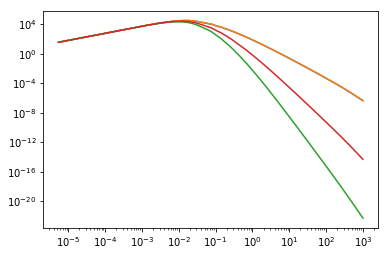

In [52]:
plt.loglog(pk_k,pk_tot)
plt.loglog(pk_k,pk_cb)
plt.loglog(pk_k,pk_nu)
plt.loglog(pk_k,pk_nu_cb)

In [53]:
pk_cb_int = interp1d(pk_k,pk_cb)
pk_nu_int = interp1d(pk_k,pk_nu)
pk_nu_cb_int = interp1d(pk_k,pk_nu_cb)
pk_m_int = interp1d(pk_k,pk_tot)

In [54]:
filt = np.where(k<1.)

In [55]:
sys.path.append('/home/ophilcox/EffectiveHalos/')
import EffectiveHalos as ph
reload(ph);

### Using $\sum m_\nu = 0.4\,\mathrm{eV}$ with 3 degenerate states

### Load CLASS linear power spectrum

In [56]:
from classy import Class

##### we add tCl,lCl to get better precision in T(k) since uses finer grid

In [57]:
class_params = {'h':h,"T_cmb":2.7255,"Omega_b":0.049,"Omega_cdm":0.2589643720,"Omega_ncdm":"0.0031785425,0.0031785425,0.0031785425",
                "YHe":0.24,'N_ncdm':3,"n_s":0.9624,"z_pk":z,"N_ur":0.046,#0641,
                "output":"mPk,mTk",#,tCl,lCl",
               'P_k_max_h/Mpc':100,
               "A_s":2.739100e-09,"T_ncdm":"0.7133,0.7133,0.7133",
               #"tol_ncdm_synchronous":1e-10,
               #"transfer_neglect_delta_k_S_t0":100.,
               #"transfer_neglect_delta_k_S_t1":100.,
               #"transfer_neglect_delta_k_S_t2":100.,
               #"transfer_neglect_delta_k_S_e":100.,
               #"k_step_sub":0.015,
                #"k_step_super":0.0001,
                #"k_step_super_reduction":0.1,
                #"tol_ncdm_bg":1.e-10,
                #"k_scalar_min_eta0":0.002,
                #"k_scalar_max_eta0_over_l_max":3.,
                #"k_scalar_step_sub":0.015,
                #"k_scalar_step_super":0.0001, # was 0.0005
                #"k_scalar_step_transition":0.2, # was 0.2

}

In [58]:
cosm = ph.Cosmology(z,verb=True,npoints=1000,**class_params)

Loading CLASS
Using a neutrino fraction of Omega_nu = 9.536e-03


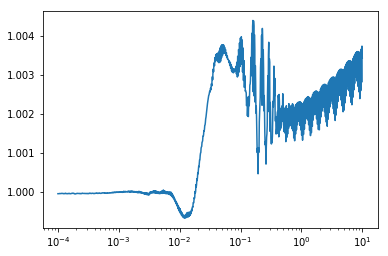

In [59]:
cosmo = Class()
cosmo.set(class_params)
cosmo.compute()
h = cosmo.h()
vector_linear_power = np.vectorize(lambda k: cosmo.pk_cb_lin(k*h,z)*h**3.)

kk = np.logspace(-4,1,1000)

plt.semilogx(kk,pk_cb_int(kk)/cosm.compute_linear_power(kk))
#plt.semilogx(kk,cosm.compute_linear_power(kk))

### Generate Halo Model

In [60]:
mf = ph.MassFunction(cosm,'Bhattacharya')
hp = ph.HaloPhysics(cosm,mf,npoints=300);

kh_min = 0.#np.pi*2./L_box

halop = ph.HaloModel(cosm,mf,hp,kk,kh_min)

Creating an interpolator for sigma(M) and its derivative.


#### Define models

In [61]:
_=halop.halo_model(1,1)
def lin_cb(pars):
    return pk_cdm_cdm(kk)
def lin_all(pars):
    return pk_cdm_cdm(kk)*(1.-f_nu)**2.+2.*f_nu*(1.-f_nu)*pk_nu_cdm(kk)+f_nu**2.*pk_nu_nu(kk)
def lin_hm_cb(pars):
    return halop.I_11**2.*pk_cdm_cdm(kk) + halop.I_20
def ehm_cb(pars):
    return halop.halo_model(pars[0],pars[1])*(1.-f_nu)**2.+2.*f_nu*(1.-f_nu)*pk_nu_cdm(kk)+f_nu**2.*pk_nu_nu(kk)
def lin_all2(pars):
    return pfull_int(kk)

In [62]:
f_nu = cosm.cosmo.Omega_nu/cosm.cosmo.Omega_m()

##### Define Schmidt correction term

In [63]:
mi = halop.mass_integrals

dn_dm = mi._compute_mass_function()
b_m = mi._compute_linear_bias()
m_u_m = mi._compute_fourier_profile()
m_u_m_0 = hp.halo_profile(mi.m_h_grid,-1,True)

n_m_u2 = dn_dm*m_u_m**2
R_L = np.power(3.*mi.m_h_grid/(4.*np.pi*cosm.rhoM),1./3.)
    
nmu2_sq = n_m_u2[:,:,np.newaxis]*n_m_u2[:,np.newaxis,:]
R_L_sum = ((R_L.reshape(-1,1)+R_L.reshape(1,-1)))[np.newaxis,:,:]
Theta = (1. + (kk[:,np.newaxis,np.newaxis]*R_L_sum)**4.)**(-1.)

one_halo_lim = simps(dn_dm*m_u_m_0**2.,mi.logM_h_grid)

I_20_corr = simps(simps(nmu2_sq*Theta,mi.logM_h_grid,axis=1),mi.logM_h_grid,axis=1)/one_halo_lim

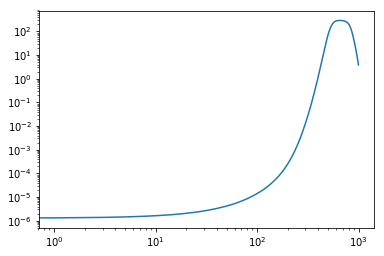

In [64]:
plt.loglog(halop.I_20-I_20_corr)

In [65]:
def pk_lin(pars):
    #return pk_cb_int(kk)*(1.-f_nu)**2.+2.*f_nu*(1.-f_nu)*pk_nu_cb_int(kk)+f_nu**2.*pk_nu_int(kk)
    return pk_m_int(kk)
def pk_shm(pars):
    # i.e. SHM applied to cb-part and linear for nu and nu-cb part
    return (1.-f_nu)**2.*(pk_cb_int(kk)*halop.I_11**2.+halop.I_20)+(pk_m_int(kk)-pk_cb_int(kk)*(1.-f_nu)**2.)
def pk_shm_naive(pars):
    # i.e. SHM applied to cb-part and linear for nu and nu-cb part
    return (pk_m_int(kk)*halop.I_11**2.+halop.I_20-I_20_corr)
def pk_shm_schmidt(pars):
    # same as pk_shm but with Schmidt low-k correction
    return (1.-f_nu)**2.*(pk_cb_int(kk)*halop.I_11**2.+halop.I_20-I_20_corr)+(pk_m_int(kk)-pk_cb_int(kk)*(1.-f_nu)**2.)
def pk_ehm(pars):
    # i.e. EHM applied to cb-part and linear for nu and nu-cb part
    hm_cb = (1.-f_nu)**2.*halop.halo_model(pars[0],pars[1])
    lin_rest = (pk_m_int(kk)-pk_cb_int(kk)*(1.-f_nu)**2.)
    return hm_cb+lin_rest
def pk_ehm_schmidt(pars):
    # same as pk_ehm but with Schmidt low-k correction
    hm_cb = (1.-f_nu)**2.*(halop.halo_model(pars[0],pars[1])-I_20_corr)
    lin_rest = (pk_m_int(kk)-pk_cb_int(kk)*(1.-f_nu)**2.)
    return hm_cb+lin_rest
def pk_ehm_schmidt(pars):
    # same as pk_ehm but with Schmidt low-k correction
    hm_cb = (1.-f_nu)**2.*(halop.halo_model(pars[0],pars[1])-I_20_corr)
    lin_rest = (pk_m_int(kk)-pk_cb_int(kk)*(1.-f_nu)**2.)
    return hm_cb+lin_rest

model = {'P_lin':pk_lin,'SHM_Naive':pk_shm_naive,'SHM':pk_shm,'SHM+low-k':pk_shm_schmidt,
         'EHM':pk_ehm,'EHM_low-k':pk_ehm_schmidt}
names = model.keys()

cols = ['red','blue','green','purple','orange','cyan','green']
k_fit = 0.8
n_fit = np.where(k<k_fit)[0][-1]

print('Fitting up to %.2f'%k[n_fit])

nbody_mean = all_Pk.mean(axis=0)
nbody_std = all_Pk.std(axis=0)/np.sqrt(len(all_Pk))

# Define covariance parameters
dk = np.mean(np.diff(k))
survey_vol = L_box**3.
N_modes = k**2.*dk*survey_vol/(2.*np.pi**2.)

   
# define bins (k-dk/2,k+dk/2)
k_lo = (k-dk/2).reshape(-1,1)
ff = np.arange(0,1,0.01).reshape(1,-1)
k_grid = k_lo+ff*dk

def bin_model(model_pk):
    interpol = interp1d(kk,model_pk)
    return simps(k_grid**2.*interpol(k_grid),k_grid,axis=1)/simps(k_grid**2.,k_grid,axis=1)

def fit_model(model):
    def chi2(par):
        pred = interp1d(kk,model(par))(k[:n_fit])#bin_model(model(par))[:n_fit]#interp1d(kk,model(par))(k[:n_fit])
        cov_Pk_diag = pred**2.*2./N_modes[:n_fit]
        prec_diag = 1./cov_Pk_diag
        prec = np.diag(prec_diag)
        diff = pred - nbody_mean[:n_fit]
        chi2val = np.matmul(diff.T,np.matmul(prec,diff))
        return chi2val
    x = minimize(chi2,[1.,1.])
    return x.x

fit_pars = []
for n,name in enumerate(names):
    print(name)
    fit_par = fit_model(model[name])
    fit_pars.append(fit_par)

In [81]:
model_ehm = pk_ehm_schmidt(fit_pars[0])
model_lin = pk_lin([])

In [77]:
# Now rebin best model
kEHM,pEHM,_ = PKL.expected_Pk(kk.astype('float32'),model_ehm.astype('float32'),L_box,1024)
kEHM = np.asarray(kEHM)
pEHM = np.asarray(pEHM)

Time take = 21.52


In [82]:
kLM,pLM,_ = PKL.expected_Pk(kk.astype('float32'),model_lin.astype('float32'),L_box,1024)
kLM = np.asarray(kLM)
pLM = np.asarray(pLM)

Time take = 22.01


('Model: "EHM_low-k", parameters: ', array([ 7.87325479e+00, -7.63443525e-03]))
('Model: "SHM+low-k", parameters: ', array([1., 1.]))
('Model: "SHM_Naive", parameters: ', array([1., 1.]))
('Model: "P_lin", parameters: ', array([1., 1.]))
('Model: "EHM", parameters: ', array([ 7.87399514e+00, -5.06534490e-03]))
('Model: "SHM", parameters: ', array([1., 1.]))


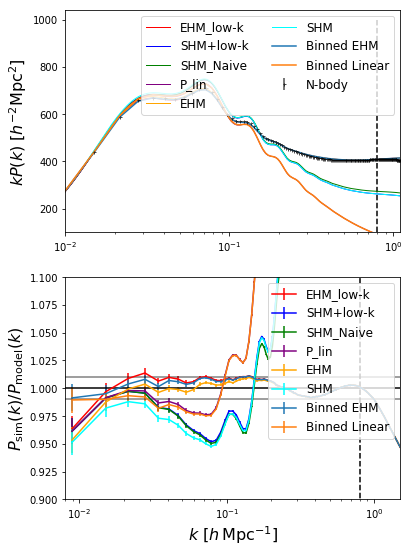

In [84]:
fig,ax = plt.subplots(2,1,figsize=(6,9))
ax[0].errorbar(k,k*nbody_mean,yerr=k*nbody_std,label='N-body',ls='',marker='+',ms=3,c='k',alpha=0.7)
for n,name in enumerate(names):
    fit_par = fit_pars[n]
    print('Model: "%s", parameters: '%name,fit_par)
    pred = model[name](fit_par)
    alp = 1.
    lw = 1
    ax[0].plot(kk,kk*pred,label=name,alpha=alp,c=cols[n],lw=lw)
ax[0].plot(kEHM,kEHM*pEHM,label='Binned EHM')
ax[0].plot(kLM,kLM*pLM,label='Binned Linear')
ax[0].legend(fontsize=12,ncol=2)
ax[0].set_ylim([100.,1040])
ax[0].vlines(k_fit,0,1000,color='k',alpha=1.,linestyles='--')
ax[0].set_ylabel(r'$kP(k)$ [$h^{-2}\mathrm{Mpc}^{2}$]',fontsize=16)
#ax[0].set_xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=16)
ax[0].set_xlim([0.01,1.1]);
ax[0].set_xscale('log')

for n,name in enumerate(names):
    fit_par = fit_pars[n]
    #pred = interp1d(kk,model[name](fit_par))(k)
    pred = bin_model(model[name](fit_par))
    ax[1].errorbar(k,nbody_mean/pred,yerr=nbody_std/pred,label=name,alpha=alp,c=cols[n])
ax[1].errorbar(kEHM,nbody_mean/pEHM,yerr=nbody_std/pEHM,label='Binned EHM')
ax[1].errorbar(kLM,nbody_mean/pLM,yerr=nbody_std/pLM,label='Binned Linear')
ax[1].set_ylabel(r'$P_\mathrm{sim}(k)/P_\mathrm{model}(k)$',fontsize=16)
ax[1].set_xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=16)
ax[1].hlines(1.,0.001,10.,color='k',alpha=1)
ax[1].hlines([0.99,1.01],0.001,10.,color='k',alpha=0.5)
ax[1].vlines(k_fit,0,2,color='k',alpha=1.,linestyles='--')
ax[1].set_ylim([0.9,1.1])
ax[1].set_xscale('log')
ax[1].legend(fontsize=12,ncol=1,loc='upper right')
ax[1].set_xlim([0.008,1.5]);

### Seems like binning is useful here!

### Should properly fold this in with $c_s^2$, i.e. optimize parameters afterwards? Or wait forever?

In [184]:
dk = np.mean(np.diff(k))

In [203]:
# define bins (k-dk/2,k+dk/2)
k_lo = (k-dk/2).reshape(-1,1)
ff = np.arange(0,1,0.001).reshape(1,-1)
k_grid = k_lo+ff*dk

mean_pk = simps(k_grid**2.*pk_m_int(k_grid),k_grid,axis=1)/simps(k_grid**2.,k_grid,axis=1)

Text(0.5,1,'Mnu_ppp sims at z = 0')

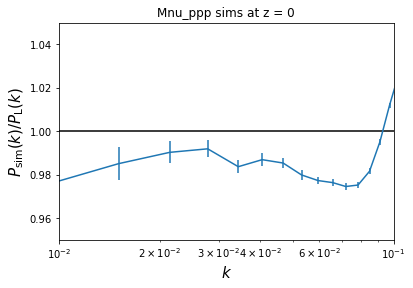

In [87]:
inp_int = interp1d(inp_k,inp_m)
plt.errorbar(k,nbody_mean/pk_m_int(k),yerr=nbody_std/pk_m_int(k))
plt.xscale('log')
#plt.errorbar(k,nbody_mean/mean_pk,yerr=nbody_std/mean_pk)
plt.xlim([1e-2,0.1])
plt.hlines(1,1e-3,1)
plt.ylim([0.95,1.05])
plt.ylabel(r'$P_\mathrm{sim}(k)/P_\mathrm{L}(k)$',fontsize=15)
plt.xlabel(r'$k$',fontsize=15)
plt.title('Mnu_ppp sims at z = 0')

Text(0.5,1,'Mnu_ppp sims at z = 0')

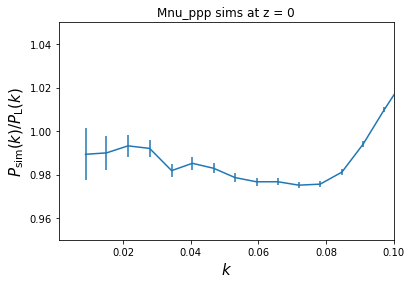

In [241]:
inp_int = interp1d(inp_k,inp_m)
plt.errorbar(k,nbody_mean/bin_pk,yerr=nbody_std/bin_pk)
#plt.errorbar(k,nbody_mean/mean_pk,yerr=nbody_std/mean_pk)
plt.xlim([1e-3,0.1])
plt.ylim([0.95,1.05])
plt.ylabel(r'$P_\mathrm{sim}(k)/P_\mathrm{L}(k)$',fontsize=15)
plt.xlabel(r'$k$',fontsize=15)
plt.title('Mnu_ppp sims at z = 0')

### Use CLASS transfer functions?
Probably can avoid doing this in practice.

In [321]:
kk = np.logspace(-4,1,1000)

In [322]:
prim = cosmo.get_primordial()

In [323]:
prim_k = prim['k [1/Mpc]']
prim_calP = prim['P_scalar(k)'] # k^3 P(k) / (2 pi^2)
prim_calP_int = interp1d(prim_k,prim_calP)

In [324]:
trans = cosmo.get_transfer(0.)
trans_k = trans['k (h/Mpc)']
trans_cdm = interp1d(trans_k*cosmo.h(),trans['d_cdm'])
trans_m = interp1d(trans_k*cosmo.h(),trans['d_tot'])

pk_cdmT_p = lambda kp: prim_calP_int(kp)*trans_cdm(kp)**2.*(2.*np.pi**2.)/(kp**3.)
pk_cdmT = lambda kh: pk_cdmT_p(kh*h)*h**3.

pk_mT_p = lambda kp: prim_calP_int(kp)*trans_m(kp)**2.*(2.*np.pi**2.)/(kp**3.)
pk_mT = lambda kh: pk_mT_p(kh*h)*h**3.

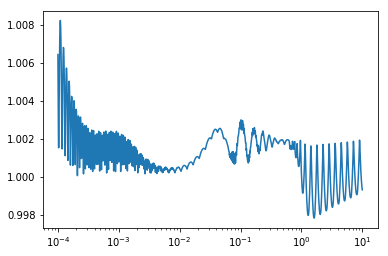

In [325]:
vector_pk_m = np.vectorize(lambda k: cosmo.pk_lin(k*cosmo.h(),z)*cosmo.h()**3.)
plt.semilogx(kk,pk_cdmT(kk)/cosm.compute_linear_power(kk))

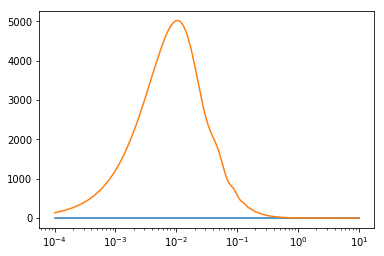

In [326]:
plt.semilogx(kk,prim_calP_int(kk))
plt.semilogx(kk,prim_calP_int(kk)*trans_cdm(kk)**2./kk**3.)

In [92]:
primordial = cosmo.get_primordial()
primTmp = interp1d(primordial['k [1/Mpc]'],primordial['P_scalar(k)'])
primInt = lambda k: primTmp(k*h)*h**3.

#### Generate Transfer functions

In [105]:
Omb=cosm.cosmo.Omega_b()
Omm=cosm.cosmo.Omega_m()

In [107]:
transfers = cosmo.get_transfer(0.,'camb')
tK = transfers['k (h/Mpc)']
tCB = interp1d(tK,transfers['-T_cdm/k2']*(Omm-Omb)/Omm+transfers['-T_b/k2']*Omb/Omm)
tM = interp1d(tK,transfers['-T_tot/k2'])
tN = interp1d(tK,transfers['-T_ncdm/k2'])

#### Generate $P_{cc}, P_{\nu\nu}, P_{\nu c}$

# NB: can we reduce the wigglyness in these transfer fns? 
probably some class parameter for this

In [127]:
pk_nu_nu = lambda k: primInt(k)*tN(k)**2.*k*h*(2.*np.pi**2.)
pk_nu_c = lambda k: primInt(k)*tN(k)*tCB(k)*k*h*(2.*np.pi**2.)
pk_c_c = lambda k: primInt(k)*tCB(k)**2.*k*h*(2.*np.pi**2.)
pk_m_m = lambda k: primInt(k)*tM(k)**2.*k*h*(2.*np.pi**2.)

f_nu = cosm.cosmo.Omega_nu/cosmo.Omega_m()
print("Neutrino fraction: %.4f"%f_nu)

Neutrino fraction: 0.0300


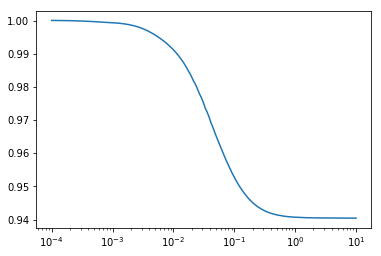

In [129]:
plt.semilogx(kk,pk_m_m(kk)/pk_c_c(kk))

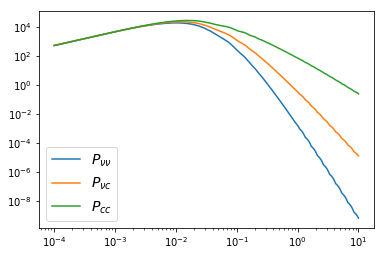

In [125]:
plt.loglog(kk,pk_nu_nu(kk),label=r'$P_{\nu\nu}$')
plt.loglog(kk,pk_nu_c(kk),label=r'$P_{\nu c}$')
plt.loglog(kk,pk_c_c(kk),label=r'$P_{cc}$')
plt.legend(fontsize=14);

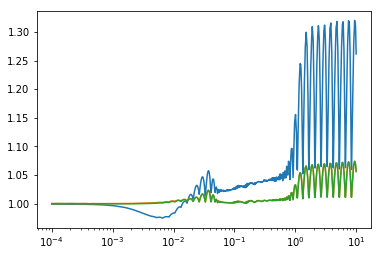

In [133]:
inp_int_cb = interp1d(inp_k,inp_cb)
inp_int_n = interp1d(inp_k,inp_n)
inp_int_m = interp1d(inp_k,inp_m)
plt.semilogx(kk,pk_nu_nu(kk)/inp_int_n(kk),label=r'\nu\nu')
plt.semilogx(kk,pk_c_c(kk)/inp_int_cb(kk),label='cc')
plt.semilogx(kk,pk_m_m(kk)/inp_int_m(kk),label='cc')

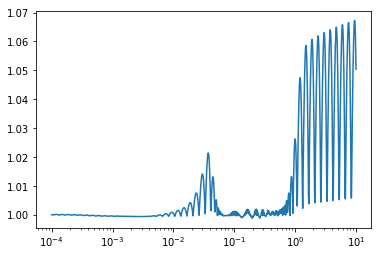

In [144]:
vector_pk_m = np.vectorize(lambda k: cosmo.pk_lin(k*h,z)*h**3.)
plt.semilogx(kk,pk_m_m(kk)/vector_pk_m(kk))

In [17]:
mf = ph.MassFunction(cosm,'Bhattacharya')
hp = ph.HaloPhysics(cosm,mf,npoints=300);

kh_min = 0.#np.pi*2./L_box

halop = ph.HaloModel(cosm,mf,hp,kk,kh_min)

Creating an interpolator for sigma(M) and its derivative.


### Define models

In [55]:
_=halop.halo_model(1,1)
def lin_cb(pars):
    return pk_cdm_cdm(kk)
def lin_all(pars):
    return pk_cdm_cdm(kk)*(1.-f_nu)**2.+2.*f_nu*(1.-f_nu)*pk_nu_cdm(kk)+f_nu**2.*pk_nu_nu(kk)
def lin_hm_cb(pars):
    return halop.I_11**2.*pk_cdm_cdm(kk) + halop.I_20
def ehm_cb(pars):
    return halop.halo_model(pars[0],pars[1])*(1.-f_nu)**2.+2.*f_nu*(1.-f_nu)*pk_nu_cdm(kk)+f_nu**2.*pk_nu_nu(kk)
def lin_all2(pars):
    return pfull_int(kk)

In [56]:
model = {'LinCB':lin_cb,'LinAll':lin_all,'LinHM_CB':lin_hm_cb,'LinAll2':lin_all2,'EHM':ehm_cb}#,r'$P_\mathrm{L}$':lin_2h}
names = model.keys()

In [57]:
cols = ['red','blue','green','purple','orange','cyan','green']
k_fit = 1.
n_fit = np.where(k<k_fit)[0][-1]

print('Fitting up to %.2f'%k[n_fit])

nbody_mean = all_Pk.mean(axis=0)
nbody_std = all_Pk.std(axis=0)/np.sqrt(len(all_Pk))

# Define covariance parameters
dk = np.mean(np.diff(k))
survey_vol = L_box**3.
N_modes = k**2.*dk*survey_vol/(2.*np.pi**2.)

def fit_model(model):
    def chi2(par):
        pred = interp1d(kk,model(par))(k[:n_fit])
        cov_Pk_diag = pred**2.*2./N_modes[:n_fit]
        prec_diag = 1./cov_Pk_diag
        prec = np.diag(prec_diag)
        diff = pred - nbody_mean[:n_fit]
        chi2val = np.matmul(diff.T,np.matmul(prec,diff))
        return chi2val
    x = minimize(chi2,[1.,1.])
    return x.x

fit_pars = []
for n,name in enumerate(names):
    fit_par = fit_model(model[name])
    fit_pars.append(fit_par)

Fitting up to 1.00


('Model: "LinHM_CB", parameters: ', array([1., 1.]))
('Model: "EHM", parameters: ', array([8.02955544, 0.29399385]))
('Model: "LinAll2", parameters: ', array([1., 1.]))
('Model: "LinAll", parameters: ', array([1., 1.]))
('Model: "LinCB", parameters: ', array([1., 1.]))


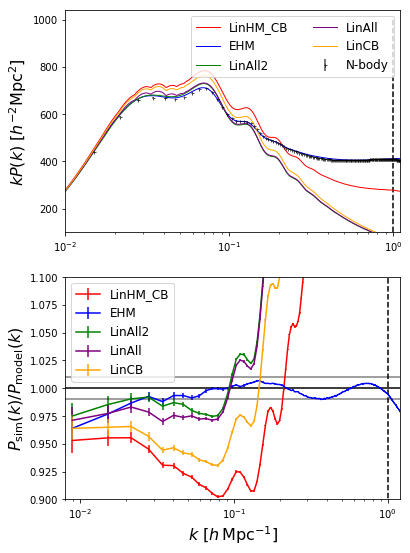

In [58]:
fig,ax = plt.subplots(2,1,figsize=(6,9))
ax[0].errorbar(k,k*nbody_mean,yerr=k*nbody_std,label='N-body',ls='',marker='+',ms=3,c='k',alpha=0.7)
for n,name in enumerate(names):
    fit_par = fit_pars[n]
    print('Model: "%s", parameters: '%name,fit_par)
    pred = model[name](fit_par)
    alp = 1.
    lw = 1
    ax[0].plot(kk,kk*pred,label=name,alpha=alp,c=cols[n],lw=lw)
ax[0].legend(fontsize=12,ncol=2)
ax[0].set_ylim([100.,1040])
ax[0].vlines(k_fit,0,1000,color='k',alpha=1.,linestyles='--')
ax[0].set_ylabel(r'$kP(k)$ [$h^{-2}\mathrm{Mpc}^{2}$]',fontsize=16)
#ax[0].set_xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=16)
ax[0].set_xlim([0.01,1.1]);
ax[0].set_xscale('log')

for n,name in enumerate(names):
    fit_par = fit_pars[n]
    pred = interp1d(kk,model[name](fit_par))(k)
    ax[1].errorbar(k,nbody_mean/pred,yerr=nbody_std/pred,label=name,alpha=alp,c=cols[n])
ax[1].set_ylabel(r'$P_\mathrm{sim}(k)/P_\mathrm{model}(k)$',fontsize=16)
ax[1].set_xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=16)
ax[1].hlines(1.,0.001,10.,color='k',alpha=1)
ax[1].hlines([0.99,1.01],0.001,10.,color='k',alpha=0.5)
ax[1].vlines(k_fit,0,2,color='k',alpha=1.,linestyles='--')
ax[1].set_ylim([0.9,1.1])
ax[1].set_xscale('log')
ax[1].legend(fontsize=12,ncol=1)
ax[1].set_xlim([0.008,1.2]);

In [26]:
# def fid_model(pars):
#     return halop.halo_model(pars[0],pars[1],'EFT',1,1,1)
# def lin_model(pars):
#     return halop.halo_model(pars[0],pars[1],'Linear',0,0,0)
# def lin_2h(pars):
#     return halop.non_linear_power(pars[0],pars[1],'Linear',0,0,0)

##### Define model with one-halo correction term as in Schmidt 2016

In [18]:
mi = halop.mass_integrals

dn_dm = mi._compute_mass_function()
b_m = mi._compute_linear_bias()
m_u_m = mi._compute_fourier_profile()
m_u_m_0 = hp.halo_profile(mi.m_h_grid,-1,True)

n_m_u2 = dn_dm*m_u_m**2
R_L = np.power(3.*mi.m_h_grid/(4.*np.pi*cosm.rhoM),1./3.)
    
nmu2_sq = n_m_u2[:,:,np.newaxis]*n_m_u2[:,np.newaxis,:]
R_L_sum = ((R_L.reshape(-1,1)+R_L.reshape(1,-1)))[np.newaxis,:,:]
Theta = (1. + (kk[:,np.newaxis,np.newaxis]*R_L_sum)**4.)**(-1.)

one_halo_lim = simps(dn_dm*m_u_m_0**2.,mi.logM_h_grid)

CosmoSevereError: 

Error in Class: spectra_pk_at_k_and_z(L:665) :condition ((k < 0.) || (k > exp(psp->ln_k[psp->ln_k_size-1]))) is true; k=7.215265e+01 out of bounds [0.000000e+00:7.064763e+01]

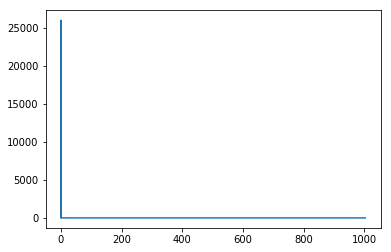

In [17]:
plt.plot(dd[:,0],dd[:,1])
plt.plot(dd[:,0],cosm.compute_linear_power(dd[:,0]))

In [19]:
one_halo_comp = simps(n_m_u2/(1.+1j*(kk.reshape(-1,1)*R_L.reshape(1,-1))),mi.logM_h_grid,axis=1)
one_halo_lim = simps(dn_dm*m_u_m_0**2.,mi.logM_h_grid)

corr_term = np.real(one_halo_comp*np.conj(one_halo_comp))/one_halo_lim

In [20]:
corr_term = simps(simps(nmu2_sq*Theta,mi.logM_h_grid,axis=1),mi.logM_h_grid,axis=1)/one_halo_lim

In [21]:
_=halop.halo_model(1,1)
mod_1h = halop.I_20 - corr_term

/home/ophilcox/.conda/envs/ptenv/lib/python2.7/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


In [22]:
one_halo_comp.shape

(1000,)

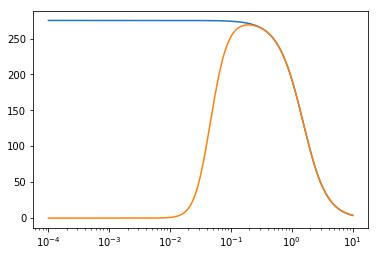

In [23]:
plt.plot(kk,halop.I_20)
plt.plot(kk,mod_1h)
plt.xscale('log')

In [24]:
def schmidt_1h(pars):
    tmp = halop.halo_model(pars[0],pars[1],'EFT',1,1,1)
    return tmp - corr_term

In [25]:
model = {'SHM':lin_model,'EHM':fid_model,'EHM + Schmidt':schmidt_1h,r'$P_\mathrm{L}$':lin_2h}
names = model.keys()

#### Fit models and plot

In [26]:
cols = ['red','blue','green','purple','orange','cyan','green']
k_fit = 1.
n_fit = np.where(k<k_fit)[0][-1]

print('Fitting up to %.2f'%k[n_fit])

nbody_mean = all_Pk.mean(axis=0)
nbody_std = all_Pk.std(axis=0)/np.sqrt(len(all_Pk))

# Define covariance parameters
dk = np.mean(np.diff(k))
survey_vol = L_box**3.
N_modes = k**2.*dk*survey_vol/(2.*np.pi**2.)

def fit_model(model):
    def chi2(par):
        pred = interp1d(kk,model(par))(k[:n_fit])
        cov_Pk_diag = pred**2.*2./N_modes[:n_fit]
        prec_diag = 1./cov_Pk_diag
        prec = np.diag(prec_diag)
        diff = pred - nbody_mean[:n_fit]
        chi2val = np.matmul(diff.T,np.matmul(prec,diff))
        return chi2val
    x = minimize(chi2,[1.,1.])
    return x.x

fit_pars = []
for n,name in enumerate(names):
    fit_par = fit_model(model[name])
    fit_pars.append(fit_par)

Fitting up to 1.00


('Model: "$P_\\mathrm{L}$", parameters: ', array([1., 1.]))
('Model: "EHM", parameters: ', array([7.60497049, 0.42693362]))
('Model: "SHM", parameters: ', array([1., 1.]))
('Model: "EHM + Schmidt", parameters: ', array([7.60315123, 0.42897538]))


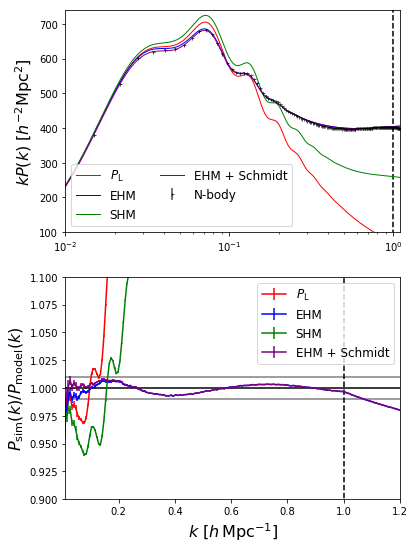

In [27]:
fig,ax = plt.subplots(2,1,figsize=(6,9))
ax[0].errorbar(k,k*nbody_mean,yerr=k*nbody_std,label='N-body',ls='',marker='+',ms=3,c='k',alpha=0.7)
for n,name in enumerate(names):
    fit_par = fit_pars[n]
    print('Model: "%s", parameters: '%name,fit_par)
    pred = model[name](fit_par)
    alp = 1.
    lw = 1
    ax[0].plot(kk,kk*pred,label=name,alpha=alp,c=cols[n],lw=lw)
ax[0].legend(fontsize=12,ncol=2)
ax[0].set_ylim([100.,740])
ax[0].vlines(k_fit,0,1000,color='k',alpha=1.,linestyles='--')
ax[0].set_ylabel(r'$kP(k)$ [$h^{-2}\mathrm{Mpc}^{2}$]',fontsize=16)
#ax[0].set_xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=16)
ax[0].set_xlim([0.01,1.1]);
ax[0].set_xscale('log')

for n,name in enumerate(names):
    fit_par = fit_pars[n]
    pred = interp1d(kk,model[name](fit_par))(k)
    ax[1].errorbar(k,nbody_mean/pred,yerr=nbody_std/pred,label=name,alpha=alp,c=cols[n])
ax[1].set_ylabel(r'$P_\mathrm{sim}(k)/P_\mathrm{model}(k)$',fontsize=16)
ax[1].set_xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=16)
ax[1].hlines(1.,0.001,10.,color='k',alpha=1)
ax[1].hlines([0.99,1.01],0.001,10.,color='k',alpha=0.5)
ax[1].vlines(k_fit,0,2,color='k',alpha=1.,linestyles='--')
ax[1].set_ylim([0.9,1.1])
#ax[1].set_xscale('log')
ax[1].legend(fontsize=12,ncol=1)
ax[1].set_xlim([0.01,1.2]);

##### nb: we need very large cut-off radius to get the results correct here. 

It works if we cut-off at k ~ 1/(R_Lag(m1) + R_Lag(m2)) but this is somewhat arbitrary

('Model: "$P_\\mathrm{L}$", parameters: ', array([1., 1.]))
('Model: "EHM", parameters: ', array([7.60497049, 0.42693362]))
('Model: "SHM", parameters: ', array([1., 1.]))
('Model: "EHM + Schmidt", parameters: ', array([7.60315123, 0.42897538]))


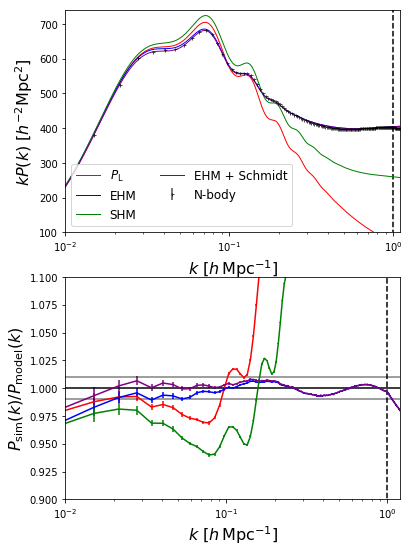

In [28]:
fig,ax = plt.subplots(2,1,figsize=(6,9))
ax[0].errorbar(k,k*nbody_mean,yerr=k*nbody_std,label='N-body',ls='',marker='+',ms=3,c='k',alpha=0.7)
for n,name in enumerate(names):
    fit_par = fit_pars[n]
    print('Model: "%s", parameters: '%name,fit_par)
    pred = model[name](fit_par)
    alp = 1.
    lw = 1
    ax[0].plot(kk,kk*pred,label=name,alpha=alp,c=cols[n],lw=lw)
ax[0].legend(fontsize=12,ncol=2)
ax[0].set_ylim([100.,740])
ax[0].vlines(k_fit,0,1000,color='k',alpha=1.,linestyles='--')
ax[0].set_ylabel(r'$kP(k)$ [$h^{-2}\mathrm{Mpc}^{2}$]',fontsize=16)
ax[0].set_xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=16)
ax[0].set_xlim([0.01,1.1]);
ax[0].set_xscale('log')

for n,name in enumerate(names):
    fit_par = fit_pars[n]
    pred = interp1d(kk,model[name](fit_par))(k)
    ax[1].errorbar(k,nbody_mean/pred,yerr=nbody_std/pred,label=name,alpha=alp,c=cols[n])
ax[1].set_ylabel(r'$P_\mathrm{sim}(k)/P_\mathrm{model}(k)$',fontsize=16)
ax[1].set_xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=16)
ax[1].hlines(1.,0.001,10.,color='k',alpha=1)
ax[1].hlines([0.99,1.01],0.001,10.,color='k',alpha=0.5)
ax[1].vlines(k_fit,0,2,color='k',alpha=1.,linestyles='--')
ax[1].set_ylim([0.9,1.1])
ax[1].set_xscale('log')
ax[1].set_xlim([0.01,1.2]);

#### Try out Valageas 1-halo model

In [146]:
from scipy.integrate import simps
mass_integ = halop.mass_integrals
n_m = mass_integ._compute_mass_function()
m_u_m = mass_integ._compute_fourier_profile()
m_norm = hp.halo_profile(mass_integ.m_h_grid,k,1)

In [147]:
def th_ex(k,m):
    RL = np.power(3.*m/(4.*np.pi*cosm.rhoM),1./3.) # lagrangian radius
    kR = k.reshape(-1,1)*RL.reshape(1,-1)
    Wk = 3.*(np.sin(kR)-kR*np.cos(kR))/(kR**3.)
    return Wk

In [148]:
WkR = th_ex(k,mass_integ.m_h_grid)*m_norm;

In [149]:
i20 = simps(m_u_m**2.*n_m,mass_integ.logM_h_grid)
i20_ex = simps(n_m*(m_u_m-WkR)**2.,mass_integ.logM_h_grid)

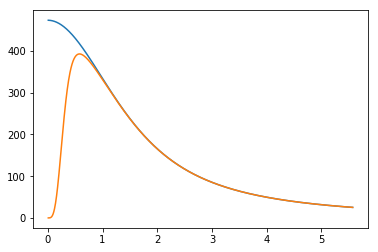

In [150]:
plt.plot(k,i20)
plt.plot(k,i20_ex)

### Try out Baldauf 2-halo model

In [186]:
from scipy.integrate import simps
mass_integ = halop.mass_integrals
n_m = mass_integ._compute_mass_function()
m_u_m = mass_integ._compute_fourier_profile()
b_m = mass_integ._compute_linear_bias()

In [202]:
n1 = n_m.reshape(1,-1,1)
n2 = n_m.reshape(1,1,-1)
b1 = b_m.reshape(1,-1,1)
b2 = b_m.reshape(1,1,-1)
mum1 = m_u_m[:,:,np.newaxis]
mum2 = m_u_m[:,np.newaxis,:]

def mass_to_Lag(m,odelta=200):
    return np.power(3.*m/(4.*odelta*np.pi*cosm.rhoM),1./3.)
R_ex = mass_to_Lag(mass_integ.m_h_grid.reshape(-1,1)+mass_integ.m_h_grid.reshape(1,-1))
V_ex = (4.*np.pi*R_ex**3./3.)[np.newaxis,:,:]

In [203]:
P2h_ex = - simps(simps(n1*n2*mum1*mum2*V_ex,mass_integ.logM_h_grid,axis=1),mass_integ.logM_h_grid,axis=1)

In [204]:
from mcfit import P2xi, xi2P
from scipy.interpolate import interp1d, interp2d

In [205]:
# Define a power spectrum
kk = np.logspace(-4,1,10000)
pp = cosm.compute_linear_power(kk)

# Transform to real space for convolution
r,xi = P2xi(kk,lowring=False)(pp)

# Define interpolation grid
RR = np.linspace(0,max(R_ex.ravel())+10,1000)

# Multiply in real-space and transform
xi = np.vstack([xi for _ in range(len(RR))])
xi[r.reshape(1,-1)>RR.reshape(-1,1)]=0.

# Interpolate into one dimension and return
kk,pp = xi2P(r,lowring=False)(xi)
int2d = interp2d(kk,RR,pp)
int1d = interp1d(RR,int2d(k,RR).T)
P_V_int = int1d


In [206]:
p_v_conv = P_V_int(R_ex)

In [207]:
P2h_ex2 = - simps(simps(n1*n2*mum1*mum2*p_v_conv,mass_integ.logM_h_grid*b1*b2,axis=1),mass_integ.logM_h_grid,axis=1)

In [208]:
_=halop.halo_model(1,1)

In [209]:
P2L = halop.I_11**2.*cosm.compute_linear_power(k)
P1h = halop.I_20

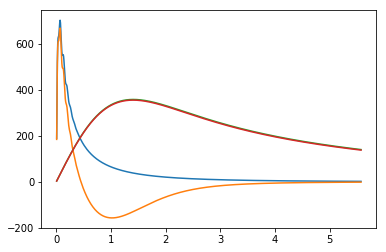

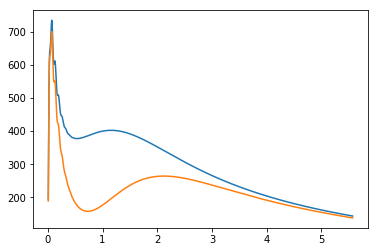

In [215]:
#plt.plot(k,(P2h_ex*0+P2h_ex2)*k)
plt.plot(k,P2L*k)
plt.plot(k,k*(P2L+P2h_ex2));
plt.plot(k,k*P1h)
plt.plot(k,k*(P1h+P2h_ex));
plt.figure()
plt.plot(k,k*(P2L+P1h))
plt.plot(k,k*(P2L+P2h_ex2+P2h_ex+P1h))

In [252]:
def zelNoCt(pars):
    return halop.I_11**2.*zP  + halop.I_20
def zelLinCt(pars):
    return halop.I_11**2.*(zP - pars[0]*k**2./(1.+k**2.)*lP)*halop._compute_smoothing_function(pars[1])**2. + halop.I_20
    #return zP + (1. - 1./(1.+k**2*26**2.))*1./(1.+k**2.*pars[0]**2.)

def zelZelCt(pars):
    return halop.I_11**2.*(zP - pars[0]*k**2./(1.+0*k**2.)*zP)*halop._compute_smoothing_function(pars[1])**2. + halop.I_20

def compHalo(pars):
    return halop.halo_model(pars[0],pars[1],'EFT',1,1,1) - halop.I_20 + i20_ex
def twoHalo(pars):
    return halop.halo_model(pars[0],pars[1],'EFT',1,0,1) - halop.I_20

def GaussSmooth(pars):
    return (halop.halo_model(pars[0],pars[1],'EFT',1,0,1)-halop.I_20)*np.exp(-k**2.*pars[1]**2.)+halop.I_20

In [253]:
# names = ['Full Model','Linear','Zel`dovich','Zel`dovich + Counterterm','CompHalo','TwoHalo','GaussSmooth']
# model = {'Full Model':P1,'Linear':P6,'Zel`dovich':zelNoCt,'Zel`dovich + Counterterm':zelLinCt,'CompHalo':compHalo,
#         'TwoHalo':twoHalo,'GaussSmooth':GaussSmooth}

In [257]:
names = ['Linear','Full Model','Gaussian Smoothing']
model = {'Linear':P6,'Full Model':P1,'Gaussian Smoothing':GaussSmooth}

In [260]:
cols = ['blue','red','green']#purple','orange','cyan','green']
k_fit = 0.8
n_fit = np.where(k<k_fit)[0][-1]

print('Fitting up to %.2f'%k[n_fit])

nbody_mean = all_Pk.mean(axis=0)
nbody_std = all_Pk.std(axis=0)/np.sqrt(len(all_Pk))

# Define covariance parameters
dk = np.mean(np.diff(k))
survey_vol = L_box**3.
N_modes = k**2.*dk*survey_vol/(2.*np.pi**2.)

def fit_model(model):
    def chi2(par):
        pred = model(par)[:n_fit]
        cov_Pk_diag = pred**2.*2./N_modes[:n_fit]
        prec_diag = 1./cov_Pk_diag
        prec = np.diag(prec_diag)
        diff = pred - nbody_mean[:n_fit]
        chi2val = np.matmul(diff.T,np.matmul(prec,diff))
        return chi2val
    x = minimize(chi2,[1.,1.])
    return x.x

fit_pars = []
for n,name in enumerate(names):
    fit_par = fit_model(model[name])
    fit_pars.append(fit_par)

Fitting up to 0.79


('Model: "Linear", parameters: ', array([1., 1.]))
('Model: "Full Model", parameters: ', array([9.26330539, 1.71138959]))
('Model: "Gaussian Smoothing", parameters: ', array([9.23145391, 0.78168098]))


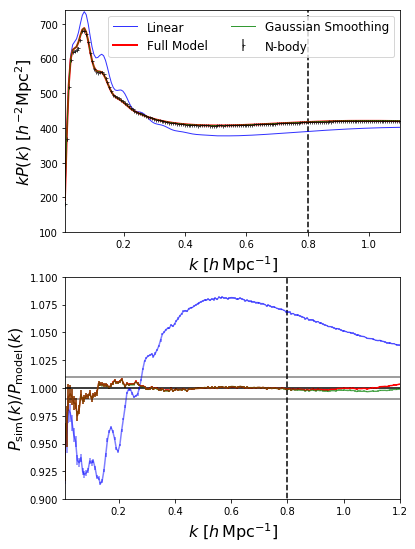

In [263]:
fig,ax = plt.subplots(2,1,figsize=(6,9))
ax[0].errorbar(k,k*nbody_mean,yerr=k*nbody_std,label='N-body',ls='',marker='+',ms=3,c='k',alpha=0.7)
for n,name in enumerate(names):
    fit_par = fit_pars[n]
    print('Model: "%s", parameters: '%name,fit_par)
    pred = model[name](fit_par)
    if name!='Full Model':
        alp=0.8
        lw=1
    else:
        alp=1.
        lw=2
    ax[0].plot(k,k*pred,label=name,alpha=alp,c=cols[n],lw=lw)
#plt.plot(k,k*(p2halo+p1halo),label='HM')
#plt.plot(k,k*p1halo,label='1-halo term')
#plt.xscale('log')
ax[0].legend(fontsize=12,ncol=2)
#plt.gca().legend(bbox_to_anchor=(1.,0.6),fontsize=14,ncol=2);
ax[0].set_ylim([100.,740])
ax[0].vlines(k_fit,0,1000,color='k',alpha=1.,linestyles='--')
ax[0].set_ylabel(r'$kP(k)$ [$h^{-2}\mathrm{Mpc}^{2}$]',fontsize=16)
ax[0].set_xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=16)
ax[0].set_xlim([0.01,1.1]);

for n,name in enumerate(names):
    fit_par = fit_pars[n]
    pred = model[name](fit_par)
    if name!='Full Model':
        alp=0.5
    else:
        alp=1.
    ax[1].errorbar(k,nbody_mean/pred,yerr=nbody_std/pred,label=name,alpha=alp,c=cols[n])
#plt.errorbar(k,nbody_mean/(p2halo+p1halo),yerr=nbody_std/(p2halo+p1halo),label='HM')
#ax[1].set_xscale('log')
#plt.legend()
ax[1].set_ylabel(r'$P_\mathrm{sim}(k)/P_\mathrm{model}(k)$',fontsize=16)
ax[1].set_xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=16)
#plt.gca().legend(bbox_to_anchor=(1.,0.5),fontsize=14);
ax[1].hlines(1.,0.001,10.,color='k',alpha=1)
ax[1].hlines([0.99,1.01],0.001,10.,color='k',alpha=0.5)
ax[1].vlines(k_fit,0,2,color='k',alpha=1.,linestyles='--')
ax[1].set_ylim([0.9,1.1])
ax[1].set_xlim([0.01,1.2]);
#fig.savefig('Quijote_comparison_Pk.pdf',bbox_inches='tight')

In [144]:
zelNo = zelNoCt(fit_model(zelNoCt))
zelLin = zelLinCt(fit_model(zelLinCt))
zelZel = zelZelCt(fit_model(zelZelCt))
#zel

In [146]:
fit_model(zelLinCt)

array([-3.432224  ,  1.54282851])

('Model: "Full Model", parameters: ', array([9.26328748, 1.71139476]))


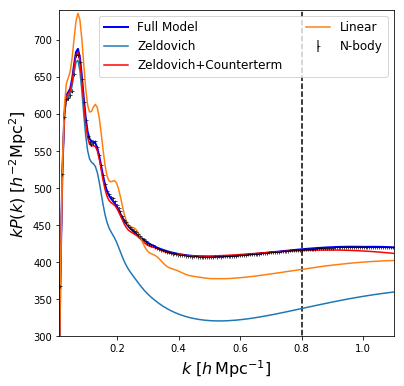

In [138]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.errorbar(k,k*nbody_mean,yerr=k*nbody_std,label='N-body',ls='',marker='+',ms=3,c='k',alpha=0.7)
cut_names = ['Full Model']#, 'Vanilla']
for n,name in enumerate(cut_names):
    fit_par = fit_pars[n]
    print('Model: "%s", parameters: '%name,fit_par)
    pred = model[name](fit_par)
    if name!='Full Model':
        alp=0.8
        lw=1
    else:
        alp=1.
        lw=2
    ax.plot(k,k*pred,label=name,alpha=alp,c=cols[n],lw=lw)
ax.plot(k,k*zelMod,label='Zeldovich')
ax.plot(k,k*zelCtMod(zelPar),label='Zeldovich+Counterterm',c='r')
ax.plot(k,k*linMod,label='Linear')
#plt.plot(k,k*p1halo,label='1-halo term')
#plt.xscale('log')
ax.legend(fontsize=12,ncol=2)
#plt.gca().legend(bbox_to_anchor=(1.,0.6),fontsize=14,ncol=2);
ax.set_ylim([300.,740])
ax.vlines(k_fit,0,1000,color='k',alpha=1.,linestyles='--')
ax.set_ylabel(r'$kP(k)$ [$h^{-2}\mathrm{Mpc}^{2}$]',fontsize=16)
ax.set_xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=16)
ax.set_xlim([0.01,1.1]);

(0.95, 1.05)

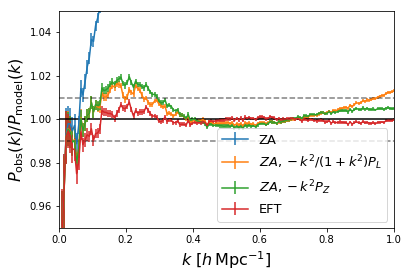

In [139]:
plt.errorbar(k,nbody_mean/zelNo,yerr=nbody_std/zelNo,label='ZA')
plt.errorbar(k,nbody_mean/zelLin,yerr=nbody_std/zelLin,label=r'$ZA, -k^2/(1+k^2)P_L$')
plt.errorbar(k,nbody_mean/zelZel,yerr=nbody_std/zelZel,label=r'$ZA, -k^2P_Z$')
plt.errorbar(k,nbody_mean/pred,yerr=nbody_std/pred,label='EFT')
plt.xlim([0.,1.])
plt.ylabel(r'$P_\mathrm{obs}(k)/P_\mathrm{model}(k)$',fontsize=16)
plt.xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=16)
plt.legend(fontsize=13)
plt.hlines([0.99,1.01],0,1,linestyles='--',alpha=0.5)
plt.hlines(1,0,1)
plt.ylim([0.95,1.05])

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(6,9))
ax[0].errorbar(k,k*nbody_mean,yerr=k*nbody_std,label='N-body',ls='',marker='+',ms=3,c='k',alpha=0.7)
for n,name in enumerate(names):
    fit_par = fit_pars[n]
    print('Model: "%s", parameters: '%name,fit_par)
    pred = model[name](fit_par)
    if name!='Full Model':
        alp=0.8
        lw=1
    else:
        alp=1.
        lw=2
    ax[0].plot(k,k*pred,label=name,alpha=alp,c=cols[n],lw=lw)
#plt.plot(k,k*(p2halo+p1halo),label='HM')
#plt.plot(k,k*p1halo,label='1-halo term')
#plt.xscale('log')
ax[0].legend(fontsize=12,ncol=2)
#plt.gca().legend(bbox_to_anchor=(1.,0.6),fontsize=14,ncol=2);
ax[0].set_ylim([300.,740])
ax[0].vlines(k_fit,0,1000,color='k',alpha=1.,linestyles='--')
ax[0].set_ylabel(r'$kP(k)$ [$h^{-2}\mathrm{Mpc}^{2}$]',fontsize=16)
ax[0].set_xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=16)
ax[0].set_xlim([0.01,1.1]);

for n,name in enumerate(names):
    fit_par = fit_pars[n]
    pred = model[name](fit_par)
    if name!='Full Model':
        alp=0.5
    else:
        alp=1.
    ax[1].errorbar(k,nbody_mean/pred,yerr=nbody_std/pred,label=name,alpha=alp,c=cols[n])
#plt.errorbar(k,nbody_mean/(p2halo+p1halo),yerr=nbody_std/(p2halo+p1halo),label='HM')
ax[1].set_xscale('log')
#plt.legend()
ax[1].set_ylabel(r'$P_\mathrm{sim}(k)/P_\mathrm{model}(k)$',fontsize=16)
ax[1].set_xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=16)
#plt.gca().legend(bbox_to_anchor=(1.,0.5),fontsize=14);
ax[1].hlines(1.,0.001,10.,color='k',alpha=1)
ax[1].hlines([0.99,1.01],0.001,10.,color='k',alpha=0.5)
ax[1].vlines(k_fit,0,2,color='k',alpha=1.,linestyles='--')
ax[1].set_ylim([0.9,1.1])
ax[1].set_xlim([0.01,2.]);
#fig.savefig('Quijote_comparison_Pk.pdf',bbox_inches='tight')

('Model: "Full Model", parameters: ', array([ 9.26324138,  1.71141581]))
('Model: "No IR", parameters: ', array([ 9.24038268,  1.70087261]))
('Model: "No Truncation", parameters: ', array([ 10.44060487,   1.        ]))
('Model: "No Counterterm", parameters: ', array([ 1.        ,  3.68228258]))
('Model: "No Pade", parameters: ', array([ 6.53245888,  1.7000137 ]))
('Model: "Vanilla", parameters: ', array([ 1.,  1.]))


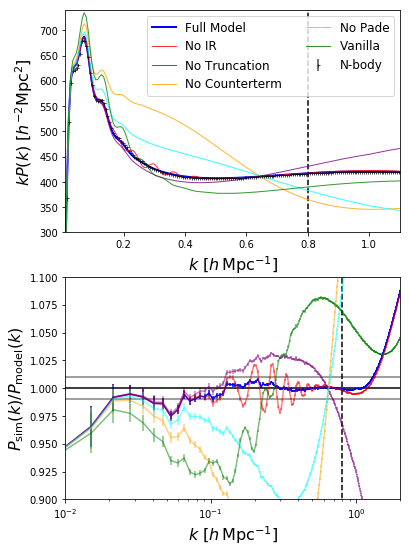

In [42]:
fig,ax = plt.subplots(2,1,figsize=(6,9))
ax[0].errorbar(k,k*nbody_mean,yerr=k*nbody_std,label='N-body',ls='',marker='+',ms=3,c='k',alpha=0.7)
for n,name in enumerate(names):
    fit_par = fit_pars[n]
    print('Model: "%s", parameters: '%name,fit_par)
    pred = model[name](fit_par)
    if name!='Full Model':
        alp=0.8
        lw=1
    else:
        alp=1.
        lw=2
    ax[0].plot(k,k*pred,label=name,alpha=alp,c=cols[n],lw=lw)
#plt.plot(k,k*(p2halo+p1halo),label='HM')
#plt.plot(k,k*p1halo,label='1-halo term')
#plt.xscale('log')
ax[0].legend(fontsize=12,ncol=2)
#plt.gca().legend(bbox_to_anchor=(1.,0.6),fontsize=14,ncol=2);
ax[0].set_ylim([300.,740])
ax[0].vlines(k_fit,0,1000,color='k',alpha=1.,linestyles='--')
ax[0].set_ylabel(r'$kP(k)$ [$h^{-2}\mathrm{Mpc}^{2}$]',fontsize=16)
ax[0].set_xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=16)
ax[0].set_xlim([0.01,1.1]);

for n,name in enumerate(names):
    fit_par = fit_pars[n]
    pred = model[name](fit_par)
    if name!='Full Model':
        alp=0.5
    else:
        alp=1.
    ax[1].errorbar(k,nbody_mean/pred,yerr=nbody_std/pred,label=name,alpha=alp,c=cols[n])
#plt.errorbar(k,nbody_mean/(p2halo+p1halo),yerr=nbody_std/(p2halo+p1halo),label='HM')
ax[1].set_xscale('log')
#plt.legend()
ax[1].set_ylabel(r'$P_\mathrm{sim}(k)/P_\mathrm{model}(k)$',fontsize=16)
ax[1].set_xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=16)
#plt.gca().legend(bbox_to_anchor=(1.,0.5),fontsize=14);
ax[1].hlines(1.,0.001,10.,color='k',alpha=1)
ax[1].hlines([0.99,1.01],0.001,10.,color='k',alpha=0.5)
ax[1].vlines(k_fit,0,2,color='k',alpha=1.,linestyles='--')
ax[1].set_ylim([0.9,1.1])
ax[1].set_xlim([0.01,2.]);
#fig.savefig('Quijote_comparison_Pk.pdf',bbox_inches='tight')

### Fits sims separately

In [84]:
cols = ['blue','red','purple','orange','cyan','green']
k_fit = 0.8
n_fit = np.where(k<k_fit)[0][-1]

print('Fitting up to %.2f'%k[n_fit])

nbody_mean = all_Pk.mean(axis=0)
nbody_std = all_Pk.std(axis=0)/np.sqrt(len(all_Pk))

# Define covariance parameters
dk = np.mean(np.diff(k))
survey_vol = L_box**3.
N_modes = k**2.*dk*survey_vol/(2.*np.pi**2.)

opt_par_all = fit_model(model[names[0]])

all_par = []
all_model = []
all_fix_model = []
for i in range(100):
    this_sim = all_Pk[i]
    def fit_single_model(model):
        def chi2(par):
            pred = model(par)[:n_fit]
            cov_Pk_diag = pred**2.*2./N_modes[:n_fit]
            prec_diag = 1./cov_Pk_diag
            prec = np.diag(prec_diag)
            diff = pred - this_sim[:n_fit]
            chi2val = np.matmul(diff.T,np.matmul(prec,diff))
            return chi2val
        x = minimize(chi2,[1.,1.])
        return x.x
    fit_par = fit_single_model(model[names[0]])
    all_model.append(model[names[0]](fit_par))
    all_fix_model.append(model[names[0]](opt_par_all))
    all_par.append(np.asarray(fit_par))

Fitting up to 0.79


In [ ]:
for i in range(100):
    plt.plot(k,all_Pk[i]/all_model[i],c='b',alpha=0.01)
rat = all_Pk/np.asarray(all_model)
plt.errorbar(k,rat.mean(axis=0),yerr=rat.std(axis=0)/np.sqrt(len(rat)),c='r')
plt.xlim([min(k),1.])
plt.vlines(k_fit,0.9,1.5,linestyles='--')
plt.hlines(1.01,0,1,alpha=0.5)
plt.hlines(0.99,0,1,alpha=0.5)
plt.ylim([0.95,1.05])
plt.ylabel(r'$P_\mathrm{sim}(k)/P_\mathrm{HM}(k)$',fontsize=15)
plt.xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=15);
plt.savefig('Quijote_100_separate_fits.pdf',bbox_inches='tight')

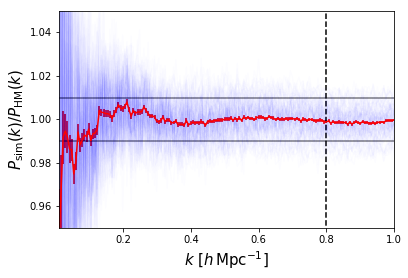

In [102]:
for i in range(100):
    plt.plot(k,all_Pk[i]/all_fix_model[i],c='b',alpha=0.01)
rat = all_Pk/np.asarray(all_fix_model)
plt.errorbar(k,rat.mean(axis=0),yerr=rat.std(axis=0)/np.sqrt(len(rat)),c='r')
plt.xlim([min(k),1.])
plt.vlines(k_fit,0.9,1.5,linestyles='--')
plt.hlines(1.01,0,1,alpha=0.5)
plt.hlines(0.99,0,1,alpha=0.5)
plt.ylim([0.95,1.05])
plt.ylabel(r'$P_\mathrm{sim}(k)/P_\mathrm{HM}(k)$',fontsize=15)
plt.xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=15);
plt.savefig('Quijote_100_combined_fits.pdf',bbox_inches='tight')

In [58]:
all_par = np.asarray(all_par)

print(all_par.mean(axis=0))
print(all_par.std(axis=0))

[2.36436653 1.26986467]
[0.04498555 0.02122323]


In [59]:
np.corrcoef(all_par.T)

array([[ 1.        , -0.77617915],
       [-0.77617915,  1.        ]])

# SCRATCH BELOW HERE!

In [35]:
m_h = np.logspace(13,15,100)
m_phys = m_h/cosm.h
R_lag = np.power(3.*m_phys/(200.*cosm.rhoM)/(4.*np.pi),1./3.)*cosm.h

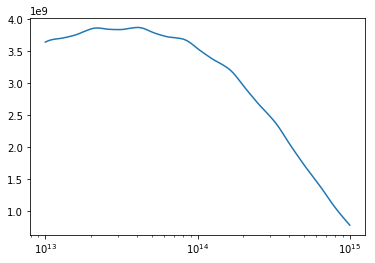

In [36]:
plt.semilogx(m_h,m_h*mf.mass_function(m_h))

### Load halo catalogs

In [24]:
import sys
import readfof
sys.path.append('/home/ophilcox/HaloPower/Pylians/library/build/lib.linux-x86_64-2.7/')

halo_snapnum = 4

# determine the redshift of the catalogue
z_dict = {4:0.0, 3:0.5, 2:1.0, 1:2.0, 0:3.0}
halo_redshift = z_dict[halo_snapnum]

assert(redshift==halo_redshift)
all_masses = []
n_halos = []

for n_sim in range(100):

    # input files
    halo_snapdir = '/projects/QUIJOTE/Halos/fiducial_HR/%d/'%n_sim #folder hosting the catalogue

    # read the halo catalogue
    FoF = readfof.FoF_catalog(halo_snapdir, halo_snapnum, long_ids=False,
                              swap=False, SFR=False, read_IDs=False)

    # get the properties of the halos
    #pos_h1 = FoF.GroupPos/1e3            #Halo positions in Mpc/h                                                                                                                                                                       
    mass1  = FoF.GroupMass*1e10          #Halo masses in Msun/h                                                                                                                                                                      
    all_masses.append(mass1)
    n_halos.append(len(mass1))
    
all_masses = np.asarray(all_masses)
n_halos = np.asarray(n_halos)
assert(len(n_halos==100))

In [25]:
np.savez('quijote_mass.npz',n_halos=n_halos,all_masses=all_masses)

### Compute some mass spectra at low N-grid

In [396]:
m_res = np.max([np.min(mm) for mm in all_masses])
print('Mass resolution: %.2e'%m_res)
mass_cuts = 10.**np.arange(12.3,13.7,0.2)
assert(min(mass_cuts)>m_res)
halos_above_M = np.asarray([[len(mm[mm>mass_cut]) for mm in all_masses] for mass_cut in mass_cuts]).T

Mass resolution: 1.64e+12


### Look at halo count covariance

In [429]:
m_res = np.max([np.min(mm) for mm in all_masses])
print('Mass resolution: %.2e'%m_res)
mass_bins = 10.**np.arange(12.3,14.,0.2)
mass_low = mass_bins[:-1]
mass_high = mass_bins[1:]
assert(min(mass_bins)>m_res)
halos_in_bin = np.asarray([[len(mm[np.logical_and(mm>=mass_low[i],mm<mass_high[i])]) for mm in all_masses] for i in range(len(mass_low))]).T

Mass resolution: 1.64e+12


### Compute ST n(M) and biases n(M)b(M) in bin

In [430]:
n_bins = len(mass_low)
n_ST = np.zeros(n_bins)
n_bias_ST = np.zeros(n_bins)
av_mass = 0.5*(np.asarray(mass_low)+np.asarray(mass_high))
for i in range(n_bins):
    mini_grid = np.linspace(np.log10(mass_low[i]),np.log10(mass_high[i]),1000)
    mini_dn_dlogM = mass_function_ST(10.**mini_grid,cosmol,z=z)/h**3.
    odelta = Dv_BryanNorman(z) # for virial definitions
    mini_bias = linear_halo_bias(10.**mini_grid,odelta,z=z)
    n_ST[i] = simps(mini_dn_dlogM,mini_grid)
    n_bias_ST[i] = simps(mini_dn_dlogM*mini_bias,mini_grid)

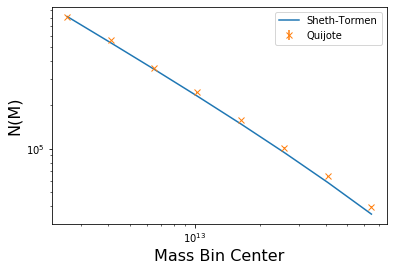

In [431]:
plt.plot(av_mass,n_ST*1e9,label='Sheth-Tormen')
plt.errorbar(av_mass,halos_in_bin.mean(axis=0),yerr=halos_in_bin.std(axis=0),marker='x',ls='',label='Quijote')
plt.legend();
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N(M)',fontsize=16)
plt.xlabel('Mass Bin Center',fontsize=16);

### Compute estimate of $\sigma^2(V_s)$

In [432]:
survey_vol = 1000**3.
survey_R = 1000.#(3.*survey_vol/(4.*np.pi))**(1./3.)
sigma2_Vs = ccl.sigmaR(cosmol,survey_R/h)**2.

## NB: $\sigma^2(V_s)$ has $\mathcal{O}(1)$ uncertainty

In [433]:
cov_counts = np.cov(halos_in_bin.T)
n_bins = len(cov_counts)
def cov_model(bin_1,bin_2):
    out = survey_vol**2*n_bias_ST[bin_1]*n_bias_ST[bin_2]*sigma2_Vs/3
    out+=(bin_1==bin_2)*n_bias_ST[bin_1]*survey_vol
    return out

In [434]:
model_cov = np.zeros_like(cov_counts)
c=['r','b','g','k','purple']
for i in range(n_bins):
    for j in range(n_bins):
        model_cov[i,j]=cov_model(i,j)

### extra / 2 to make things work

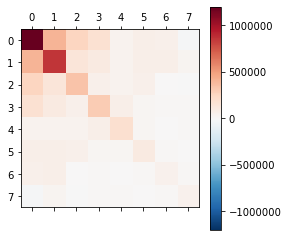

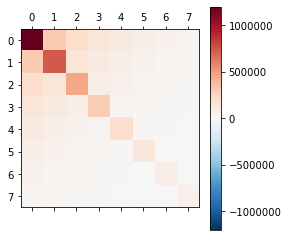

In [435]:
vmax = np.max(cov_counts)
plt.matshow(cov_counts,cmap=cm.RdBu_r,vmax=vmax,vmin=-vmax);plt.colorbar();
plt.matshow(model_cov,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);plt.colorbar();

## Define covariance between $N(m\in [M_0,M_1])$ and $P(k)$

In [436]:
n_sims = len(halos_in_bin)

diff_N = halos_in_bin - halos_in_bin.mean(axis=0)
diff_Pk = all_Pk - all_Pk.mean(axis=0)

cov_Nm_Pk = np.zeros([len(diff_N[0]),len(diff_Pk[0])])
err_cov = np.zeros_like(cov_Nm_Pk)

cov_Nm_Pk = np.matmul(diff_N.T,diff_Pk)
cov_Nm_Pk/=(n_sims-1)

all_cov_est = []
for n in range(n_sims):
    this_cov = np.zeros_like(cov_Nm_Pk)
    one_less_N = np.concatenate([diff_N[:n],diff_N[n+1:]])
    one_less_Pk = np.concatenate([diff_Pk[:n],diff_Pk[n+1:]])
    this_cov = np.matmul(one_less_N.T,one_less_Pk)
    this_cov/=(n_sims-2)
    all_cov_est.append(this_cov)
all_cov_est = np.asarray(all_cov_est)
jackknife_cov_err = np.sqrt(((all_cov_est-all_cov_est.mean(axis=0))**2).sum(axis=0)/(n_sims-1))

In [437]:
comb_Pk = np.zeros((len(all_Pk),len(all_Pk[0])//4))
comb_k = np.zeros(len(all_Pk[0])//4)
for i in range(len(all_Pk[0])):
    try:
        comb_Pk[:,i//4]+=all_Pk[:,i]*k[i]
        comb_k[i//4]+=k[i]
    except IndexError:
        break
comb_k/=4.
comb_Pk/=(4.*comb_k)

diff_comb_Pk = comb_Pk - comb_Pk.mean(axis=0)

comb_cov_Nm_Pk = np.zeros([len(diff_N[0]),len(diff_comb_Pk[0])])

comb_cov_Nm_Pk = np.matmul(diff_N.T,diff_comb_Pk)
comb_cov_Nm_Pk/=(n_sims-1)

all_comb_cov_est = []
for n in range(n_sims):
    this_comb_cov = np.zeros_like(cov_Nm_Pk)
    one_less_N = np.concatenate([diff_N[:n],diff_N[n+1:]])
    one_less_comb_Pk = np.concatenate([diff_comb_Pk[:n],diff_comb_Pk[n+1:]])
    this_comb_cov = np.matmul(one_less_N.T,one_less_comb_Pk)
    this_comb_cov/=(n_sims-2)
    all_comb_cov_est.append(this_comb_cov)
all_comb_cov_est = np.asarray(all_comb_cov_est)
jackknife_comb_cov_err = np.sqrt(((all_comb_cov_est-all_comb_cov_est.mean(axis=0))**2).sum(axis=0)/(n_sims-1))

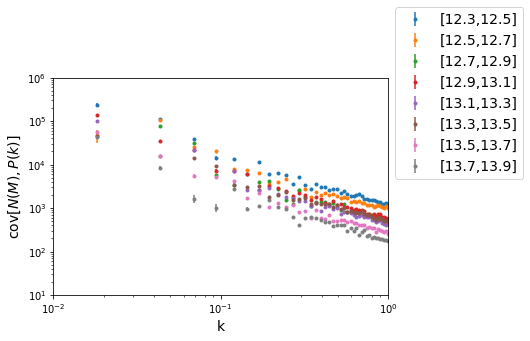

In [438]:
for i in range(n_bins):
    plt.errorbar(comb_k,-comb_cov_Nm_Pk[i],yerr=jackknife_comb_cov_err[i],
                 label=r'[%.1f,%.1f]'%(np.log10(mass_low[i]),np.log10(mass_high[i])),ls='',marker='.')
plt.legend();
plt.ylabel(r'$\mathrm{cov}\left[N(M),P(k)\right]$',fontsize=14)
plt.xlabel('k',fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.xlim([1e-2,1]);
plt.ylim([10,1e6]);
plt.gca().legend(bbox_to_anchor=(1.,0.5),fontsize=14);

## NB: extra -1 here?

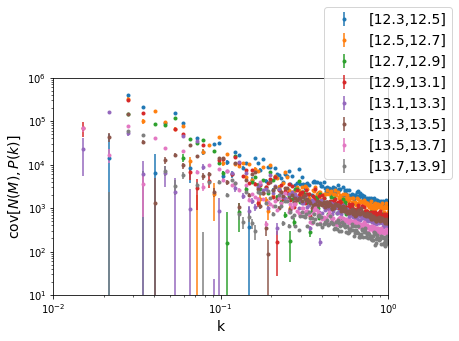

In [442]:
for i in range(n_bins):
    plt.errorbar(k,-cov_Nm_Pk[i],yerr=jackknife_cov_err[i],
                 label=r'[%.1f,%.1f]'%(np.log10(mass_low[i]),np.log10(mass_high[i])),ls='',marker='.')
plt.legend();
plt.ylabel(r'$\mathrm{cov}\left[N(M),P(k)\right]$',fontsize=14)
plt.xlabel('k',fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.xlim([1e-2,1]);
plt.ylim([10,1e6]);
plt.gca().legend(bbox_to_anchor=(1.,0.5),fontsize=14);

### Compute model covariances

In [469]:
class N_P_cov:
    ## Class to hold N(M), P(k) model
    
    def __init__(self,mass_min,mass_max,kh):
        self.mass_min = mass_min # in Msun/h units
        self.mass_max = mass_max
        assert self.mass_max<1e17, 'Max mass must be less than 10^17 Msun/h for CCL'
        self.kh = kh # in h/Mpc units
        self.nk = len(kh)
        
        # Compute useful quantities
        self.rho_matter = ccl.rho_x(cosmol,1.,'matter',True) # matter density
        self.odelta = Dv_BryanNorman(z) # for virial definitions
        
        # Compute arrays of quantities in this mass range
        self.logM_grid = np.linspace(np.log10(self.mass_min),np.log10(self.mass_max),1000)
        self.M_grid = 10.**self.logM_grid # Msun/h units
        self.conc_grid = halo_conc(self.M_grid,z=redshift,odelta=self.odelta)
        self.dn_dlogM_grid = np.asarray([mass_function_ST(MM,cosmol,z=z) for MM in self.M_grid])
        self.uM_rho_grid = np.asarray([window_function(self.M_grid,kk*h,z=z,odelta=self.odelta) for kk in self.kh])
        self.linear_halo_bias_grid = linear_halo_bias(self.M_grid,self.odelta,z=z)
        
        # compute mean number density
        self.nbar = simps(self.dn_dlogM_grid,self.logM_grid)
        
    def compute_two_halo_prefactor(self): 
        # Compute 2-halo prefactor
        if not hasattr(self,'two_halo_prefactor'):
        
            pref_2_halo = np.asarray([simps(two_halo_integrand(kh,logm_grid,z=redshift),logm_grid) for kh in self.kh])

            min_window = np.asarray([window_function(10.**np.min(logm_grid)*h,kk*h,z=redshift,odelta=1.) for kk in self.kh])
            zero_window = window_function(10.**np.min(logm_grid)*h,0.,z=redshift,odelta=1.)
            full_pref_2_halo = pref_2_halo + A*min_window/zero_window
            self.two_halo_prefactor = full_pref_2_halo
        return self.two_halo_prefactor
    
    def compute_modified_two_halo_prefactor(self): 
        # Compute 2-halo prefactor
        if not hasattr(self,'modified_two_halo_prefactor'):
        
            def modified_two_halo_integrand(kh,log10mass,z=redshift):
                # extra factor of linear bias here
                m = 10.**log10mass # in Msun
                m_h = m*h # in Msun/h
                k = kh*h # remove h dependence
                odelta = Dv_BryanNorman(z=redshift) # for virial definitions
                wk = window_function(m_h,k,z,odelta)
                dn_dlogM = mass_function_ST(m_h,cosmol,z=z)
                b = linear_halo_bias(m_h,odelta,z=z)
                return dn_dlogM*wk*b**2.
        
            pref_2_halo_mod = np.asarray([simps(modified_two_halo_integrand(kh,logm_grid,z=redshift),logm_grid) for kh in self.kh])
            min_window = np.asarray([window_function(10.**np.min(logm_grid)*h,kk*h,z=redshift,odelta=1.) for kk in self.kh])
            zero_window = window_function(10.**np.min(logm_grid)*h,0.,z=redshift,odelta=1.)
            full_mod_pref_2_halo = pref_2_halo_mod + A*min_window/zero_window
            self.modified_two_halo_prefactor = full_mod_pref_2_halo
        return self.modified_two_halo_prefactor
    
    def compute_modified_1halo(self): 
        # Compute 1-halo integral with extra linear bias factor
        if not hasattr(self,'modified_1halo'):
            
            def one_halo_integrand(kh,log10mass,z = redshift):
                m = 10.**log10mass # in Msun (NOT Msun/h)
                m_h = m*h # in Msun/h
                k = kh*h # remove h dependence
                odelta = Dv_BryanNorman(z) # for virial definitions
                wk = window_function(m_h,k,z,odelta)
                dn_dlogM = mass_function_ST(m_h,cosmol,z=z)
                bias = linear_halo_bias(m_h,odelta,z=z)
                return dn_dlogM*wk**2.*h**3.**bias;

            logm_grid = np.linspace(6.01,16.99,1000)
            self.modified_1halo = np.asarray([simps(one_halo_integrand(kh,logm_grid,z=redshift),logm_grid) for kh in self.kh])
        return self.modified_1halo
    
    def load_power_model(self,power_pars,pt,IR,Pade,truncate_2h=False):
        self.pk_full = pk_full(self.kh,power_pars,pt,IR,Pade)
        if IR:
            self.pk_lin = pk_lin_nw(self.kh)+np.exp(-Sigma2*self.kh**2.)*pk_lin_w(self.kh)
        else:
            self.pk_lin = pk_lin(self.kh)
        if truncate_2h:
            self.R = power_pars[-1]
            self.two_halo_window = FT_top_hat(self.kh*self.R)
            self.pk_full*= self.two_halo_window**2.
            self.pk_lin*=self.two_halo_window**2.
        else:
            self.R = 1000000 # large number
            
    def compute_sigma2R(self):
        # Compute sigma2 filtered on some large scale R
        if not hasattr(self,'sigma2'):
            Rphys = self.R/h
            self.sigma2R = ccl.sigmaR(cosmol,Rphys,a=1./(1.+z))**2.
        return self.sigma2R
    
    def compute_nbar(self):
        # Compute and return average density in this mass range
        if not hasattr(self,'nbar'):
            self.nbar = simps(self.dn_dlogM_grid,self.logM_grid)
        return self.nbar
    
    def compute_partial_prefactor(self):
        ## Compute usual 2-halo prefactor over limited mass range (i.e. n m / rho u(k). NB: bias is free and not included here)
        if not hasattr(self,'partial_prefactor'):
            self.partial_prefactor = simps(self.dn_dlogM_grid*self.uM_rho_grid,self.logM_grid)
        return self.partial_prefactor
            
    def compute_one_halo(self):
        # this term is n * u^2 * m^2 / rho^2 averaged over mass bin
        if not hasattr(self,'one_halo'):
            integ = self.uM_rho_grid**2.*self.dn_dlogM_grid
            self.one_halo = np.asarray([simps(integ[i],self.logM_grid) for i in range(self.nk)])
        return self.one_halo
    
    def compute_two_halo_b1(self,b1):
        ## Compute two halo term depending on b1
        if not hasattr(self,'two_halo_b1_unscaled'):
            self.two_halo_b1_unscaled = 2.*self.compute_partial_prefactor()*self.compute_two_halo_prefactor()*self.pk_full
        return self.two_halo_b1_unscaled*b1
    
    def compute_two_halo_b2(self,b2):
        if not hasattr(self,'two_halo_b2_unscaled'):
            self.two_halo_b2_unscaled = self.compute_two_halo_prefactor()**2.*self.pk_lin**2.
        return self.two_halo_b2_unscaled*b2
            
    def compute_two_halo_b3(self,b3):
        if not hasattr(self,'two_halo_b3_unscaled'):
            self.two_halo_b3_unscaled = self.compute_partial_prefactor()*self.compute_two_halo_prefactor()*self.pk_lin*self.compute_sigma2R()
        return self.two_halo_b3_unscaled*b3
    
    def compute_HSV_term_1h(self,b1):
        if not hasattr(self,'HSV_term_1h_unscaled'):
            self.HSV_term_1h_unscaled = self.compute_modified_1halo()*self.nbar*survey_vol
        return b1*self.HSV_term_1h_unscaled*sigma2_Vs
    
    def compute_HSV_term_2h(self,b1):
        if not hasattr(self,'HSV_term_2h_unscaled'):
            self.HSV_term_2h_unscaled = self.compute_modified_two_halo_prefactor()*self.nbar*survey_vol*self.pk_full
        return b1*self.HSV_term_2h_unscaled*sigma2_Vs
    
    def compute_covariance(self,b1,b2,b3,HSV=False):
        x =  self.compute_one_halo()+self.compute_two_halo_b1(b1)+self.compute_two_halo_b2(b2)+self.compute_two_halo_b3(b3)
        if HSV:
            x+= self.compute_HSV_term_1h(b1)+self.compute_HSV_term_2h(b1)
        return x

### NB: do we need h^3 factors in here?
### ensure we're always using the correct mass grid
### modified 2-halo term is non-trivial - possibly wrong due to extra b1 stopping consistency condition

### Now form covariance models

In [472]:
model_cov = []
for i in range(n_bins):
    this_model = N_P_cov(mass_low[i],mass_high[i],comb_k)
    this_model.load_power_model([8.4123486,1.60506271],'EFT',1,1,1)
    model_cov.append(this_model.compute_covariance(1,0,0,1))

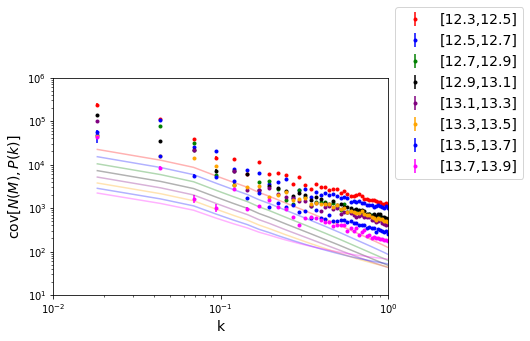

In [473]:
c=['r','b','g','k','purple','orange','blue','magenta']
for i in range(n_bins):
    plt.plot(comb_k,model_cov[i],c=c[i],alpha=0.3)
    plt.errorbar(comb_k,-comb_cov_Nm_Pk[i],yerr=jackknife_comb_cov_err[i],
                 label=r'[%.1f,%.1f]'%(np.log10(mass_low[i]),np.log10(mass_high[i])),
                 ls='',marker='.',c=c[i])
plt.legend();
plt.ylabel(r'$\mathrm{cov}\left[N(M),P(k)\right]$',fontsize=14)
plt.xlabel('k',fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.xlim([1e-2,1]);
plt.ylim([10,1e6]);
plt.gca().legend(bbox_to_anchor=(1.,0.5),fontsize=14);

In [474]:
model_cov = []
for i in range(n_bins):
    this_model = N_P_cov(mass_low[i],mass_high[i],comb_k)
    this_model.load_power_model([8.4123486,1.60506271],'EFT',1,1,1)
    model_cov.append(this_model.compute_covariance(1,0,0,0))

#### no HSV terms

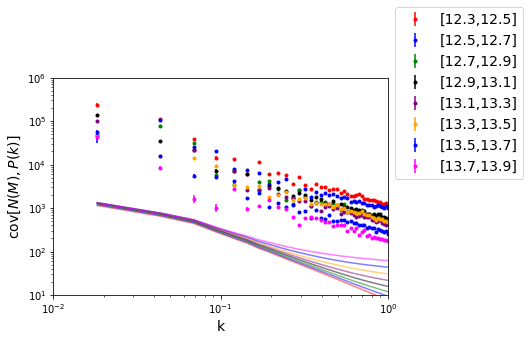

In [476]:
c=['r','b','g','k','purple','orange','blue','magenta']
for i in range(n_bins):
    plt.plot(comb_k,model_cov[i],c=c[i],alpha=0.5)
    plt.errorbar(comb_k,-comb_cov_Nm_Pk[i],yerr=jackknife_comb_cov_err[i],
                 label=r'[%.1f,%.1f]'%(np.log10(mass_low[i]),np.log10(mass_high[i])),
                 ls='',marker='.',c=c[i])
plt.legend();
plt.ylabel(r'$\mathrm{cov}\left[N(M),P(k)\right]$',fontsize=14)
plt.xlabel('k',fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.xlim([1e-2,1]);
plt.ylim([10,1e6]);
plt.gca().legend(bbox_to_anchor=(1.,0.5),fontsize=14);

### NB: b2,b3 terms are wrong here. Should probably be convolutions.

(100, 100000.0)

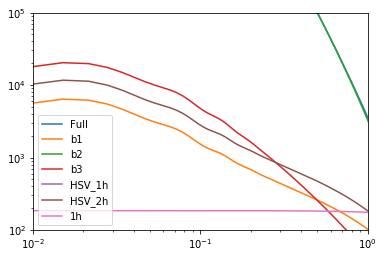

In [480]:
cov_model = N_P_cov(1e13,1e14,k)
cov_model.load_power_model([0.,1.],'EFT',1,1,1)
plt.plot(k,cov_model.compute_covariance(1,1,1),label='Full')
plt.plot(k,cov_model.compute_two_halo_b1(1),label='b1')
plt.plot(k,cov_model.compute_two_halo_b2(1),label='b2')
plt.plot(k,cov_model.compute_two_halo_b3(1),label='b3')
plt.plot(k,cov_model.compute_HSV_term_1h(1),label='HSV_1h')
plt.plot(k,cov_model.compute_HSV_term_2h(1),label='HSV_2h')
plt.plot(k,cov_model.compute_one_halo(),label='1h')
plt.yscale('log')
plt.legend();
plt.xscale('log')
plt.xlim([1e-2,1])
plt.ylim([100,1e5])